In [18]:
# ============================================================================
# CELL 1: INSTALL REQUIRED LIBRARIES
# ============================================================================

print("="*80)
print("INSTALLING REQUIRED LIBRARIES")
print("="*80)

import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✅ {package} installed")
    except:
        pass

packages = [
    "qiskit",
    "qiskit-machine-learning",
    "qiskit-aer",
    "scikit-learn",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "imbalanced-learn",
    "requests"
]

for package in packages:
    install_package(package)

print("\n✅ All libraries installed successfully!")

INSTALLING REQUIRED LIBRARIES
✅ qiskit installed
✅ qiskit-machine-learning installed
✅ qiskit-aer installed
✅ scikit-learn installed
✅ pandas installed
✅ numpy installed
✅ matplotlib installed
✅ seaborn installed
✅ imbalanced-learn installed
✅ requests installed

✅ All libraries installed successfully!


In [19]:
# ============================================================================
# CELL 2: IMPORT LIBRARIES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             roc_auc_score, precision_score, recall_score,
                             roc_curve, classification_report)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import time
import warnings
warnings.filterwarnings('ignore')

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer import Aer
from qiskit_machine_learning.kernels import FidelityQuantumKernel

print("✅ All libraries imported successfully!\n")

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

✅ All libraries imported successfully!



In [20]:
# ============================================================================
# CELL 3: CONFIGURATION (MEMORY OPTIMIZED)
# ============================================================================

# Qubit configurations to test (REDUCED for memory)
QUBIT_CONFIGS = [4, 6]  # Reduced from [4, 6, 8, 10]

# Training and test sizes (REDUCED for memory)
TRAIN_SIZE = 100  # Reduced from 300
TEST_SIZE = 80    # Reduced from 200

print("="*80)
print("ENHANCED QUANTUM vs CLASSICAL: CREDIT CARD FRAUD DETECTION")
print("="*80)
print(f"Qubit Configurations: {QUBIT_CONFIGS}")
print(f"Training samples: {TRAIN_SIZE} (balanced 50-50) - MEMORY OPTIMIZED")
print(f"Test samples: {TEST_SIZE} (with realistic imbalance)")
print(f"Feature Maps: ZZ, Pauli, EfficientSU2, Custom Dense, High Entangling, SU2")
print(f"Enhancement 1: PCA for different qubit counts")
print(f"Enhancement 2: Quantum features → Classical ML")
print(f"Enhancement 3: Comprehensive visualizations with circuits & confusion matrices")
print("="*80)

ENHANCED QUANTUM vs CLASSICAL: CREDIT CARD FRAUD DETECTION
Qubit Configurations: [4, 6]
Training samples: 100 (balanced 50-50) - MEMORY OPTIMIZED
Test samples: 80 (with realistic imbalance)
Feature Maps: ZZ, Pauli, EfficientSU2, Custom Dense, High Entangling, SU2
Enhancement 1: PCA for different qubit counts
Enhancement 2: Quantum features → Classical ML
Enhancement 3: Comprehensive visualizations with circuits & confusion matrices


In [21]:
# ============================================================================
# CELL 4: DOWNLOAD REAL CREDIT CARD FRAUD DATASET
# ============================================================================

print(f"\n{'='*80}")
print(f"DOWNLOADING REAL CREDIT CARD FRAUD DATASET")
print(f"{'='*80}")

dataset_loaded = False

# Try downloading from TensorFlow
try:
    print("Attempting to download from TensorFlow datasets...")
    import requests
    from io import StringIO

    url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
    response = requests.get(url, timeout=30)

    if response.status_code == 200:
        df = pd.read_csv(StringIO(response.text))
        print(f"✅ Downloaded successfully: {df.shape}")
        print(f"   Class distribution: {df['Class'].value_counts().to_dict()}")
        dataset_loaded = True
except Exception as e:
    print(f"⚠️  TensorFlow download failed: {str(e)}")

# Fallback: Create synthetic dataset
if not dataset_loaded:
    print("\n⚠️  Creating enhanced realistic synthetic fraud dataset...")
    np.random.seed(42)

    n_samples = 30000
    fraud_rate = 0.02

    # Normal transactions
    X_normal = np.random.randn(int(n_samples * (1 - fraud_rate)), 30)

    # Fraud transactions with clear distinguishable patterns
    X_fraud = np.random.randn(int(n_samples * fraud_rate), 30)
    X_fraud[:, 0] *= 5.0
    X_fraud[:, 1] -= 3.5
    X_fraud[:, 2] *= 4.0
    X_fraud[:, 3] += 2.0
    X_fraud[:, 4] *= 3.5
    X_fraud[:, 5:10] = np.abs(X_fraud[:, 5:10]) * 3.0
    X_fraud[:, 10:15] *= 3.0
    X_fraud[:, 15:20] -= 2.0
    X_fraud[:, 20:25] += 2.5
    X_fraud[:, 25:30] *= 2.5

    # Combine and shuffle
    X = np.vstack([X_normal, X_fraud])
    y = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_fraud))])

    shuffle_idx = np.random.permutation(len(y))
    X, y = X[shuffle_idx], y[shuffle_idx]

    # Create DataFrame
    df = pd.DataFrame(X, columns=[f'V{i}' for i in range(1, 31)])
    df['Class'] = y.astype(int)

    print(f"✅ Synthetic dataset created: {df.shape}")
    dataset_loaded = True

print(f"\n📊 Dataset Summary:")
print(f"   Total: {len(df)} transactions")
print(f"   Normal: {(df['Class']==0).sum()} ({(df['Class']==0).sum()/len(df)*100:.2f}%)")
print(f"   Fraud: {(df['Class']==1).sum()} ({(df['Class']==1).sum()/len(df)*100:.2f}%)")


DOWNLOADING REAL CREDIT CARD FRAUD DATASET
Attempting to download from TensorFlow datasets...
✅ Downloaded successfully: (284807, 31)
   Class distribution: {0: 284315, 1: 492}

📊 Dataset Summary:
   Total: 284807 transactions
   Normal: 284315 (99.83%)
   Fraud: 492 (0.17%)


In [22]:
# ============================================================================
# CELL 5: FEATURE ENGINEERING & PCA PREPARATION
# ============================================================================

print(f"\n{'='*80}")
print(f"FEATURE ENGINEERING")
print(f"{'='*80}")

# Extract features and target
X = df.drop('Class', axis=1).select_dtypes(include=[np.number])
y = df['Class']

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original features: {X_scaled.shape[1]}")
print(f"Data shape: {X_scaled.shape}")

# Prepare PCA for different qubit configurations
pca_transformers = {}
X_pca_versions = {}

for n_qubits in QUBIT_CONFIGS:
    n_components = n_qubits
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    pca_transformers[n_qubits] = pca
    X_pca_versions[n_qubits] = X_pca

    explained_var = pca.explained_variance_ratio_.sum()
    print(f"✅ PCA with {n_qubits} components: {explained_var*100:.2f}% variance explained")

print(f"\n✅ Created PCA transformations for {len(QUBIT_CONFIGS)} qubit configurations")


FEATURE ENGINEERING
Original features: 30
Data shape: (284807, 30)
✅ PCA with 4 components: 52.02% variance explained
✅ PCA with 6 components: 65.84% variance explained

✅ Created PCA transformations for 2 qubit configurations


In [23]:
# ============================================================================
# CELL 6: TRAIN-TEST SPLIT WITH BALANCED TRAINING
# ============================================================================

print(f"\n{'='*80}")
print(f"DATA PREPARATION")
print(f"{'='*80}")

def prepare_train_test(X_data, y_data, train_size, test_size):
    """Prepare balanced training and realistic test sets"""

    # Initial split
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
    )

    # Balance training data
    smote = SMOTE(k_neighbors=min((y_train_full==1).sum()-1, 5), random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_full, y_train_full)

    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

    # Sample training set
    n_per_class = min(train_size // 2,
                      (y_train_balanced==0).sum(),
                      (y_train_balanced==1).sum())

    normal_idx = np.where(y_train_balanced == 0)[0]
    fraud_idx = np.where(y_train_balanced == 1)[0]

    train_idx = np.concatenate([
        np.random.choice(normal_idx, n_per_class, replace=False),
        np.random.choice(fraud_idx, n_per_class, replace=False)
    ])
    np.random.shuffle(train_idx)

    X_train = X_train_balanced[train_idx]
    y_train = y_train_balanced[train_idx]

    # Create test set with fraud cases
    test_normal_idx = np.where(y_test_full == 0)[0]
    test_fraud_idx = np.where(y_test_full == 1)[0]

    n_fraud_test = max(int(test_size * 0.15), min(30, len(test_fraud_idx)))
    n_normal_test = test_size - n_fraud_test

    test_fraud_sample = np.random.choice(test_fraud_idx,
                                         size=min(n_fraud_test, len(test_fraud_idx)),
                                         replace=False)
    test_normal_sample = np.random.choice(test_normal_idx,
                                          size=min(n_normal_test, len(test_normal_idx)),
                                          replace=False)

    test_idx = np.concatenate([test_normal_sample, test_fraud_sample])
    np.random.shuffle(test_idx)

    X_test = X_test_full[test_idx]
    y_test = y_test_full.values[test_idx]

    return X_train, X_test, y_train, y_test

# Prepare datasets for all PCA versions
train_test_data = {}

for n_qubits in QUBIT_CONFIGS:
    X_train, X_test, y_train, y_test = prepare_train_test(
        X_pca_versions[n_qubits], y, TRAIN_SIZE, TEST_SIZE
    )

    train_test_data[n_qubits] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"✅ {n_qubits} qubits - Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"   Train - Normal: {(y_train==0).sum()}, Fraud: {(y_train==1).sum()}")
    print(f"   Test  - Normal: {(y_test==0).sum()}, Fraud: {(y_test==1).sum()}")


DATA PREPARATION
✅ 4 qubits - Train: (100, 4), Test: (80, 4)
   Train - Normal: 50, Fraud: 50
   Test  - Normal: 50, Fraud: 30
✅ 6 qubits - Train: (100, 6), Test: (80, 6)
   Train - Normal: 50, Fraud: 50
   Test  - Normal: 50, Fraud: 30


In [24]:
# ============================================================================
# CELL 7: CLASSICAL SVM BASELINE (for 4 qubits only)
# ============================================================================

print(f"\n{'='*80}")
print(f"CLASSICAL SVM BASELINE (4 Qubits PCA)")
print(f"{'='*80}")

classical_results = {}
n_qubits_baseline = 4

X_train = train_test_data[n_qubits_baseline]['X_train']
X_test = train_test_data[n_qubits_baseline]['X_test']
y_train = train_test_data[n_qubits_baseline]['y_train']
y_test = train_test_data[n_qubits_baseline]['y_test']

for kernel_name, kernel_type in [('RBF', 'rbf'), ('Poly', 'poly'), ('Linear', 'linear')]:
    print(f"\n🔵 Classical SVM ({kernel_name})...", end=' ', flush=True)
    start = time.time()

    kwargs = {'C': 0.5, 'class_weight': 'balanced', 'random_state': 42, 'probability': True}
    if kernel_type == 'poly':
        kwargs['degree'] = 3
        kwargs['gamma'] = 'auto'

    svm = SVC(kernel=kernel_type, **kwargs)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    y_proba = svm.predict_proba(X_test)[:, 1]

    classical_results[f'Classical_{kernel_name}'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba),
        'time': time.time() - start,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'cm': confusion_matrix(y_test, y_pred),
        'n_qubits': n_qubits_baseline
    }

    print(f"F1: {classical_results[f'Classical_{kernel_name}']['f1_score']:.4f} | "
          f"Recall: {classical_results[f'Classical_{kernel_name}']['recall']:.4f} | "
          f"Time: {classical_results[f'Classical_{kernel_name}']['time']:.2f}s")


CLASSICAL SVM BASELINE (4 Qubits PCA)

🔵 Classical SVM (RBF)... F1: 0.7857 | Recall: 0.7333 | Time: 0.03s

🔵 Classical SVM (Poly)... F1: 0.5532 | Recall: 0.4333 | Time: 0.02s

🔵 Classical SVM (Linear)... F1: 0.5532 | Recall: 0.4333 | Time: 0.02s


#### **Defining Quantum Feature Maps**

In [25]:
# ============================================================================
# CELL 8: DEFINE QUANTUM FEATURE MAPS
# ============================================================================

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap # EfficientSU2 removed as direct use is problematic

print(f"\n{'='*80}")
print(f"DEFINING QUANTUM FEATURE MAPS")
print(f"{'='*80}")

# Custom Feature Map inspired by a dense, strongly entangling layer
def custom_dense_feature_map(num_qubits, reps=1):
    feature_map = QuantumCircuit(num_qubits)
    params = ParameterVector('x', num_qubits)
    for i in range(num_qubits):
        feature_map.ry(params[i], i)
    for r in range(reps):
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                feature_map.cx(i, j)
    return feature_map

# Custom Highly Entangling Feature Map (often seen in VQE ansatz)
def high_entangling_feature_map(num_qubits, reps=1):
    feature_map = QuantumCircuit(num_qubits)
    params = ParameterVector('x', num_qubits)
    for i in range(num_qubits):
        feature_map.h(i) # Hadamard for superposition
        feature_map.ry(params[i], i)
    for r in range(reps):
        for i in range(num_qubits - 1):
            feature_map.cx(i, i+1)
        if num_qubits > 1:
            feature_map.cx(num_qubits-1, 0) # Cyclic entanglement
    return feature_map

# Custom EfficientSU2-like Feature Map for data encoding (num_parameters == num_qubits)
def efficient_su2_encoding_feature_map(num_qubits, reps=1, entanglement='linear'):
    qc = QuantumCircuit(num_qubits)
    x = ParameterVector('x', num_qubits) # Input classical features

    # Initial data encoding layer using input features
    for i in range(num_qubits):
        qc.ry(x[i], i)

    # Entangling layers (using CX gates, similar to EfficientSU2's structure)
    for r in range(reps):
        if entanglement == 'linear':
            for i in range(num_qubits - 1):
                qc.cx(i, i + 1)
        elif entanglement == 'full':
            for i in range(num_qubits):
                for j in range(i + 1, num_qubits):
                    qc.cx(i, j)
        # Optionally, add fixed-angle Rz gates for more complexity, but without adding new parameters
        # for i in range(num_qubits):
        #     qc.rz(np.pi/2, i)
    return qc


# Store all feature maps for each qubit configuration
all_feature_maps = {}

for n_q in QUBIT_CONFIGS:
    feature_maps_for_n_q = {
        'ZZ_FeatureMap': ZZFeatureMap(feature_dimension=n_q, reps=1, entanglement='linear', parameter_prefix='x'),
        'Pauli_FeatureMap': PauliFeatureMap(feature_dimension=n_q, reps=1, paulis=['Z', 'Y'], entanglement='linear'),
        # Using custom encoding functions for EfficientSU2 and SU2_FeatureMap
        'EfficientSU2_Encoding': efficient_su2_encoding_feature_map(num_qubits=n_q, reps=1, entanglement='linear'),
        'SU2_Encoding': efficient_su2_encoding_feature_map(num_qubits=n_q, reps=1, entanglement='full'),
        'Custom_Dense': custom_dense_feature_map(n_q, reps=1),
        'High_Entangling': high_entangling_feature_map(n_q, reps=1)
    }
    # Remove .decompose() as it might alter parameter handling for FidelityQuantumKernel
    all_feature_maps[n_q] = {k: v for k, v in feature_maps_for_n_q.items()}

print(f"✅ Defined {sum(len(v) for v in all_feature_maps.values())} feature maps across {len(QUBIT_CONFIGS)} qubit configurations.")

# Displaying an example feature map circuit for verification
print(f"\nExample: ZZFeatureMap for {QUBIT_CONFIGS[0]} qubits:")
print(all_feature_maps[QUBIT_CONFIGS[0]]['ZZ_FeatureMap'].draw(output='text', fold=-1))


DEFINING QUANTUM FEATURE MAPS
✅ Defined 12 feature maps across 2 qubit configurations.

Example: ZZFeatureMap for 4 qubits:
     ┌────────────────────────────────────┐
q_0: ┤0                                   ├
     │                                    │
q_1: ┤1                                   ├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤2                                   ├
     │                                    │
q_3: ┤3                                   ├
     └────────────────────────────────────┘


In [26]:
# ============================================================================
# CELL 9: TRAIN QUANTUM MODELS (MEMORY EFFICIENT)
# ============================================================================

print(f"\n{'='*80}")
print(f"TRAINING QUANTUM MODELS (MEMORY OPTIMIZED)")
print(f"{'='*80}")

from qiskit_aer import AerSimulator
import gc

# Use more memory-efficient simulator
backend = AerSimulator(method='statevector')
quantum_results = {}
quantum_kernels_data = {}

# Process ONE qubit configuration at a time
for n_qubits in QUBIT_CONFIGS:
    print(f"\n{'='*50}")
    print(f"TRAINING WITH {n_qubits} QUBITS")
    print(f"{'='*50}")

    X_train = train_test_data[n_qubits]['X_train']
    X_test = train_test_data[n_qubits]['X_test']
    y_train = train_test_data[n_qubits]['y_train']
    y_test = train_test_data[n_qubits]['y_test']

    feature_maps = all_feature_maps[n_qubits]
    quantum_kernels_data[n_qubits] = {}

    for fm_name, feature_map in feature_maps.items():
        model_name = f'{fm_name}_{n_qubits}Q'
        print(f"\n⚛️  {model_name}...", end=' ', flush=True)
        start_time = time.time()

        try:
            quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

            # Compute quantum kernel matrices
            K_train = quantum_kernel.evaluate(x_vec=X_train)
            K_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

            # Store kernel data for hybrid approach
            quantum_kernels_data[n_qubits][fm_name] = {
                'K_train': K_train.copy(),  # Copy to avoid reference issues
                'K_test': K_test.copy()
            }

            # Train QSVM
            qsvm = SVC(kernel='precomputed', C=0.5, class_weight='balanced',
                      random_state=42, probability=True)
            qsvm.fit(K_train, y_train)

            # Predictions
            y_pred = qsvm.predict(K_test)
            y_proba = qsvm.decision_function(K_test)

            quantum_results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'auc': roc_auc_score(y_test, y_proba),
                'time': time.time() - start_time,
                'depth': feature_map.depth(),
                'n_qubits': n_qubits,
                'feature_map': fm_name,
                'y_pred': y_pred.copy(),
                'y_proba': y_proba.copy(),
                'cm': confusion_matrix(y_test, y_pred),
                'circuit': feature_map
            }

            print(f"F1: {quantum_results[model_name]['f1_score']:.4f} | "
                  f"Time: {quantum_results[model_name]['time']:.1f}s")

            # FREE MEMORY immediately after each model
            del quantum_kernel, qsvm, y_pred, y_proba
            del K_train, K_test
            gc.collect()

        except Exception as e:
            print(f"Error: {str(e)[:50]}")
            # Clean up on error
            try:
                del quantum_kernel, K_train, K_test, qsvm
            except:
                pass
            gc.collect()

    # Force garbage collection after each qubit configuration
    gc.collect()
    print(f"\n✅ Completed {n_qubits} qubits - Memory cleared")

print(f"\n✅ Trained {len(quantum_results)} quantum models across {len(QUBIT_CONFIGS)} configurations")


TRAINING QUANTUM MODELS (MEMORY OPTIMIZED)

TRAINING WITH 4 QUBITS

⚛️  ZZ_FeatureMap_4Q... F1: 0.4348 | Time: 67.5s

⚛️  Pauli_FeatureMap_4Q... F1: 0.5278 | Time: 44.6s

⚛️  EfficientSU2_Encoding_4Q... F1: 0.6545 | Time: 18.2s

⚛️  SU2_Encoding_4Q... F1: 0.6545 | Time: 25.9s

⚛️  Custom_Dense_4Q... F1: 0.6545 | Time: 22.6s

⚛️  High_Entangling_4Q... F1: 0.6545 | Time: 25.5s

✅ Completed 4 qubits - Memory cleared

TRAINING WITH 6 QUBITS

⚛️  ZZ_FeatureMap_6Q... F1: 0.4000 | Time: 67.5s

⚛️  Pauli_FeatureMap_6Q... F1: 0.5143 | Time: 75.7s

⚛️  EfficientSU2_Encoding_6Q... F1: 0.7429 | Time: 29.9s

⚛️  SU2_Encoding_6Q... F1: 0.7429 | Time: 48.5s

⚛️  Custom_Dense_6Q... F1: 0.7429 | Time: 46.6s

⚛️  High_Entangling_6Q... F1: 0.7429 | Time: 40.1s

✅ Completed 6 qubits - Memory cleared

✅ Trained 12 quantum models across 2 configurations


In [27]:
# ============================================================================
# CELL 10: HYBRID APPROACH - QUANTUM KERNEL FEATURES → CLASSICAL ML (OPTIMIZED)
# ============================================================================

print(f"\n{'='*80}")
print(f"ENHANCEMENT 2: QUANTUM FEATURES → CLASSICAL ML (MEMORY OPTIMIZED)")
print(f"{'='*80}")

import gc

hybrid_results = {}

for n_qubits in QUBIT_CONFIGS:
    print(f"\n{'='*50}")
    print(f"HYBRID MODELS WITH {n_qubits} QUBITS")
    print(f"{'='*50}")

    y_train = train_test_data[n_qubits]['y_train']
    y_test = train_test_data[n_qubits]['y_test']

    for fm_name, kernel_data in quantum_kernels_data[n_qubits].items():
        model_name = f'Hybrid_{fm_name}_{n_qubits}Q'

        K_train = kernel_data['K_train']
        K_test = kernel_data['K_test']

        # Test ONLY SVM (removed RandomForest to save memory)
        classifiers = {
            'SVM_RBF': SVC(kernel='rbf', C=1.0, class_weight='balanced',
                          probability=True, random_state=42)
        }

        for clf_name, clf in classifiers.items():
            full_model_name = f'{model_name}_{clf_name}'
            print(f"⚛️ +🔵 {full_model_name}...", end=' ', flush=True)

            start_time = time.time()

            try:
                # Train classical model on quantum kernel features
                clf.fit(K_train, y_train)

                y_pred = clf.predict(K_test)
                y_proba = clf.predict_proba(K_test)[:, 1] if hasattr(clf, 'predict_proba') else clf.decision_function(K_test)

                hybrid_results[full_model_name] = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, zero_division=0),
                    'recall': recall_score(y_test, y_pred, zero_division=0),
                    'f1_score': f1_score(y_test, y_pred, zero_division=0),
                    'auc': roc_auc_score(y_test, y_proba),
                    'time': time.time() - start_time,
                    'n_qubits': n_qubits,
                    'feature_map': fm_name,
                    'classifier': clf_name,
                    'y_pred': y_pred.copy(),
                    'y_proba': y_proba.copy(),
                    'cm': confusion_matrix(y_test, y_pred)
                }

                print(f"F1: {hybrid_results[full_model_name]['f1_score']:.4f}")

                # Free memory
                del clf, y_pred, y_proba
                gc.collect()

            except Exception as e:
                print(f"Error: {str(e)[:30]}")
                gc.collect()

    # Clear memory after each qubit config
    gc.collect()

print(f"\n✅ Trained {len(hybrid_results)} hybrid quantum-classical models")

# Optional: Clear kernel data if still having memory issues
# del quantum_kernels_data
# gc.collect()


ENHANCEMENT 2: QUANTUM FEATURES → CLASSICAL ML (MEMORY OPTIMIZED)

HYBRID MODELS WITH 4 QUBITS
⚛️ +🔵 Hybrid_ZZ_FeatureMap_4Q_SVM_RBF... F1: 0.4000
⚛️ +🔵 Hybrid_Pauli_FeatureMap_4Q_SVM_RBF... F1: 0.5278
⚛️ +🔵 Hybrid_EfficientSU2_Encoding_4Q_SVM_RBF... F1: 0.6667
⚛️ +🔵 Hybrid_SU2_Encoding_4Q_SVM_RBF... F1: 0.6667
⚛️ +🔵 Hybrid_Custom_Dense_4Q_SVM_RBF... F1: 0.6667
⚛️ +🔵 Hybrid_High_Entangling_4Q_SVM_RBF... F1: 0.6667

HYBRID MODELS WITH 6 QUBITS
⚛️ +🔵 Hybrid_ZZ_FeatureMap_6Q_SVM_RBF... F1: 0.1765
⚛️ +🔵 Hybrid_Pauli_FeatureMap_6Q_SVM_RBF... F1: 0.5926
⚛️ +🔵 Hybrid_EfficientSU2_Encoding_6Q_SVM_RBF... F1: 0.6875
⚛️ +🔵 Hybrid_SU2_Encoding_6Q_SVM_RBF... F1: 0.6875
⚛️ +🔵 Hybrid_Custom_Dense_6Q_SVM_RBF... F1: 0.6875
⚛️ +🔵 Hybrid_High_Entangling_6Q_SVM_RBF... F1: 0.6875

✅ Trained 12 hybrid quantum-classical models


!

In [28]:
!pip install pylatexenc


ENHANCEMENT 3: VISUALIZING FEATURE MAP CIRCUITS
✅ Feature map circuits saved: quantum_feature_map_circuits.png


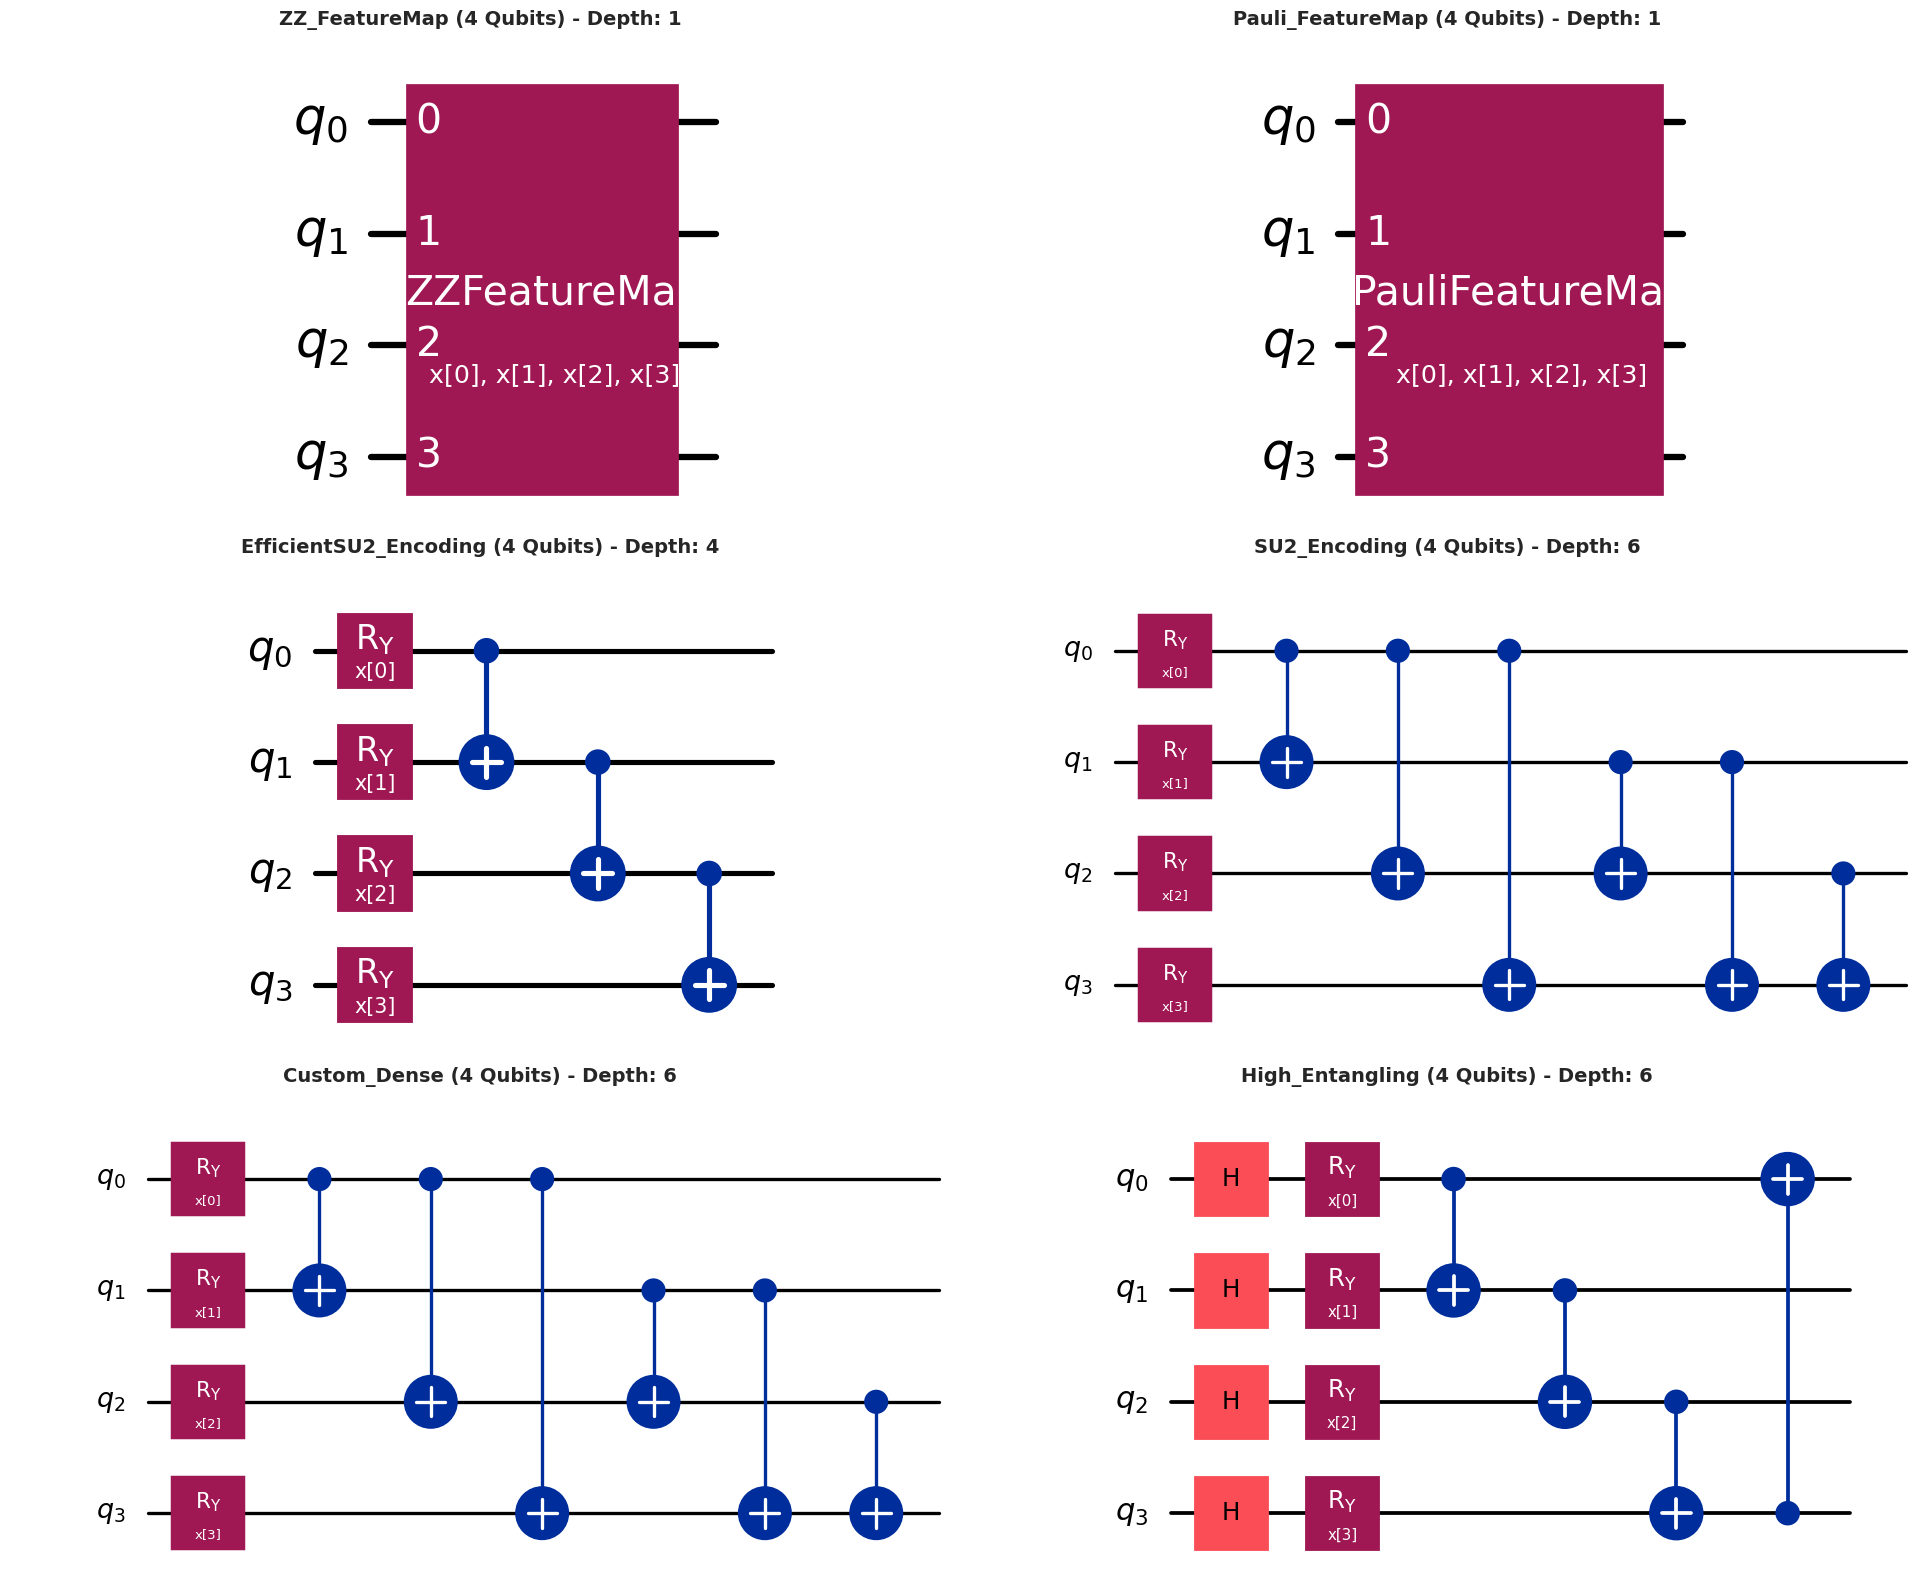

In [29]:
# ============================================================================
# CELL 11: VISUALIZE ALL FEATURE MAP CIRCUITS
# ============================================================================

print(f"\n{'='*80}")
print(f"ENHANCEMENT 3: VISUALIZING FEATURE MAP CIRCUITS")
print(f"{'='*80}")

# Select 4 qubits for detailed visualization
n_qubits_viz = 4
feature_maps_viz = all_feature_maps[n_qubits_viz]

fig = plt.figure(figsize=(20, 16))

for idx, (fm_name, circuit) in enumerate(feature_maps_viz.items(), 1):
    ax = plt.subplot(3, 2, idx)
    circuit.draw('mpl', ax=ax, style='iqp')
    ax.set_title(f'{fm_name} ({n_qubits_viz} Qubits) - Depth: {circuit.depth()}',
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('quantum_feature_map_circuits.png', dpi=300, bbox_inches='tight')
print("✅ Feature map circuits saved: quantum_feature_map_circuits.png")
plt.show()


ENHANCEMENT 3: CONFUSION MATRICES
✅ Confusion matrices saved: confusion_matrices_all_models.png


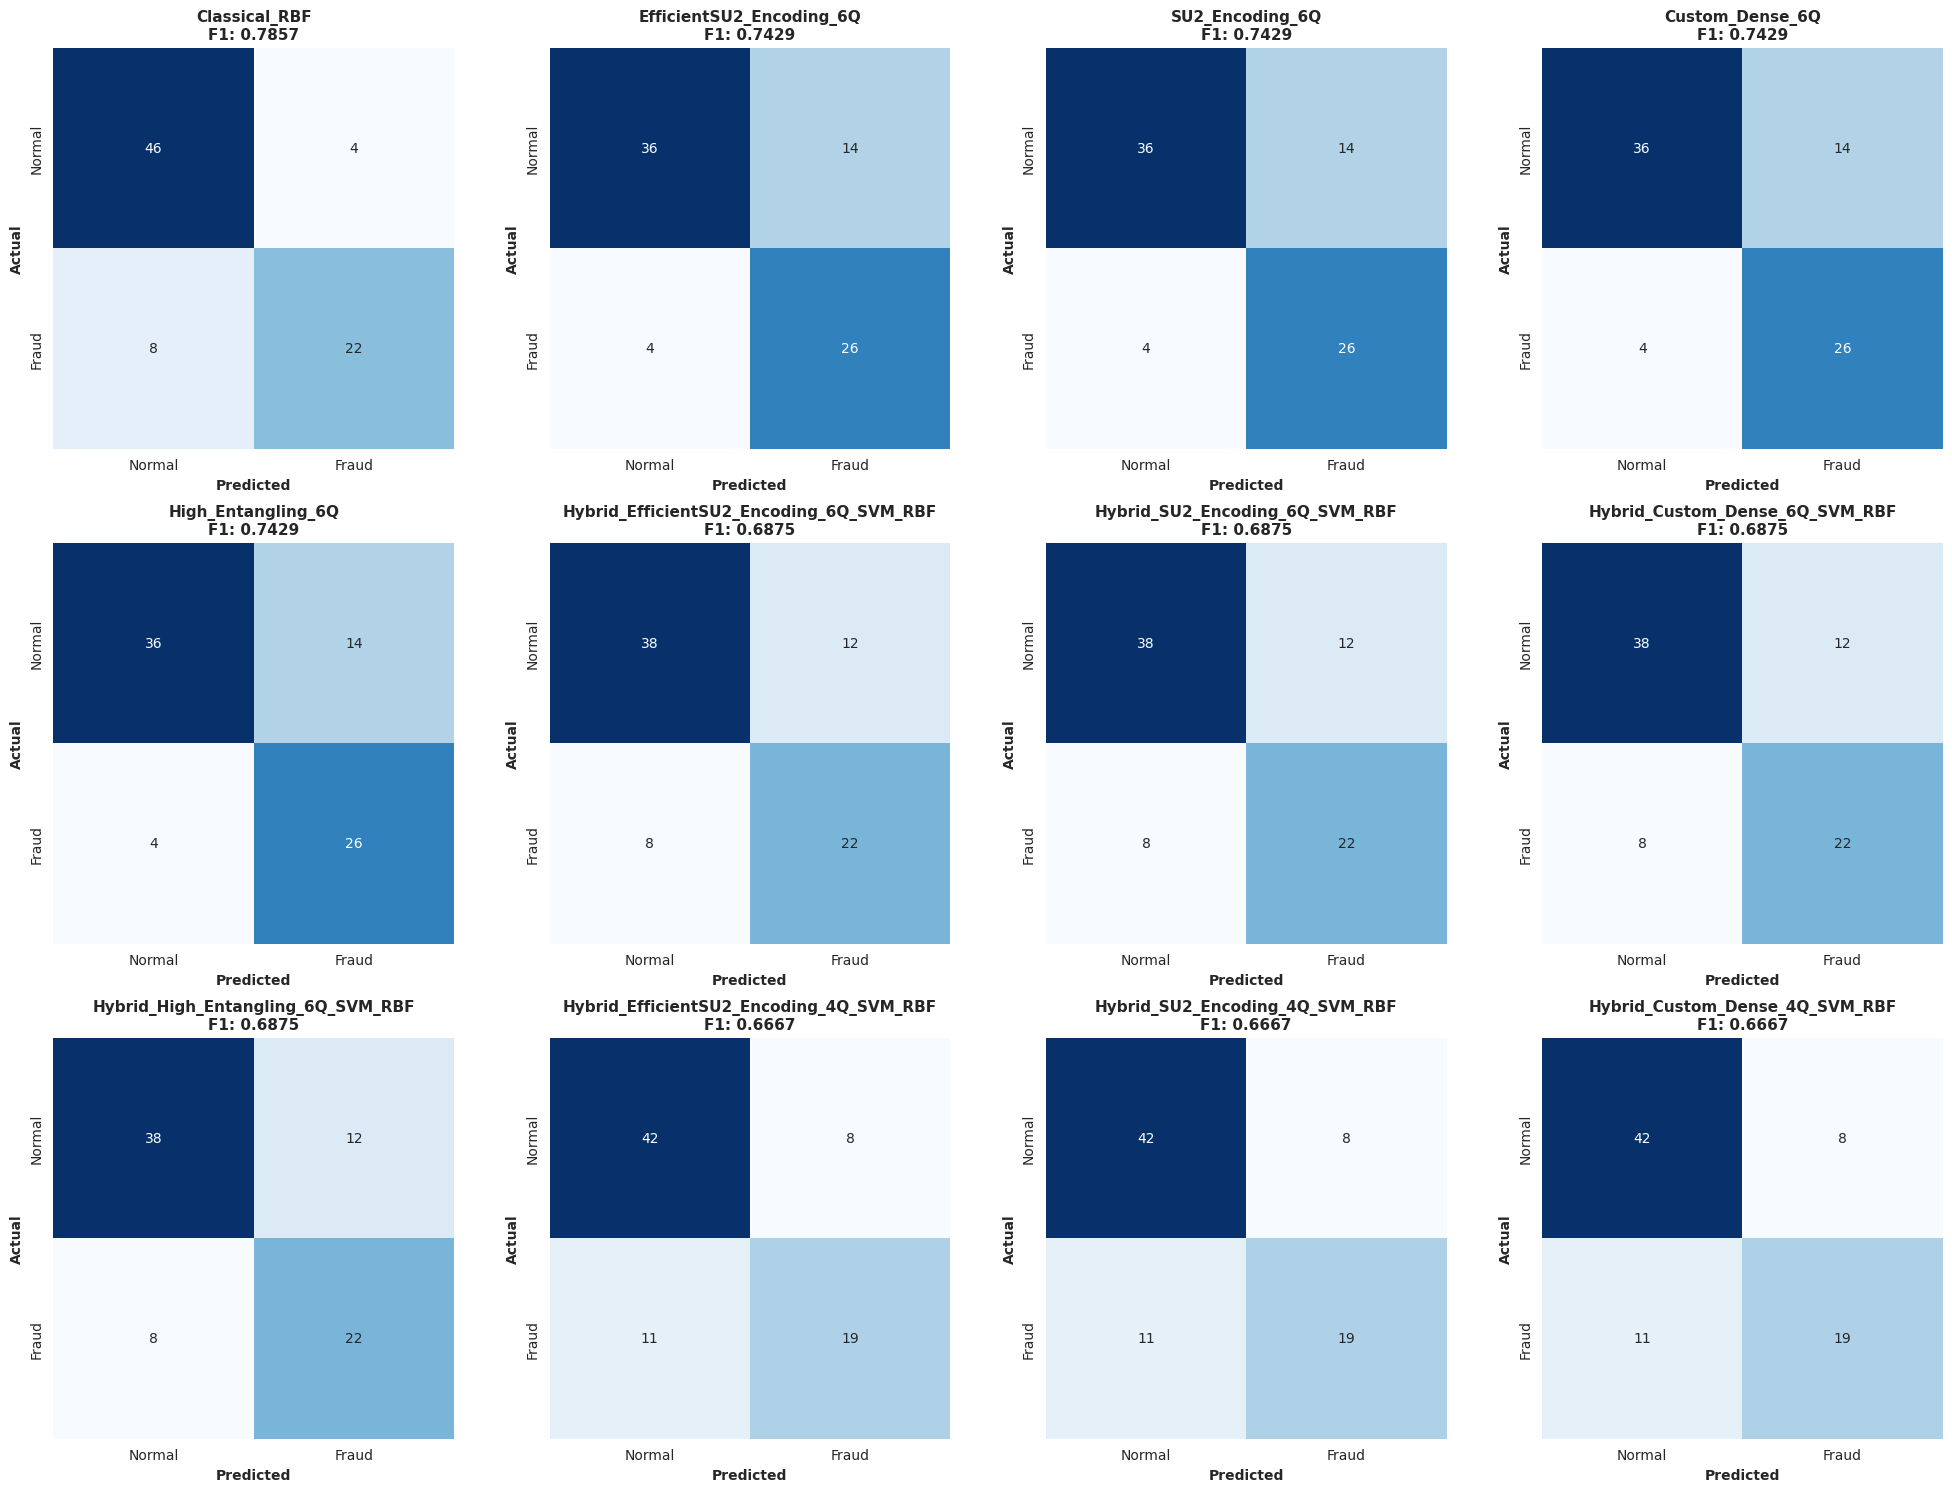

In [30]:
# ============================================================================
# CELL 12: CONFUSION MATRICES FOR ALL MODELS
# ============================================================================

print(f"\n{'='*80}")
print(f"ENHANCEMENT 3: CONFUSION MATRICES")
print(f"{'='*80}")

# Combine all results
all_results = {**classical_results, **quantum_results, **hybrid_results}

# Select top models based on F1 score
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['f1_score'], reverse=True)
top_models = sorted_models[:12]  # Top 12 models

fig = plt.figure(figsize=(20, 15))

for idx, (model_name, metrics) in enumerate(top_models, 1):
    ax = plt.subplot(3, 4, idx)

    cm = metrics['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, square=True)

    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name}\nF1: {metrics["f1_score"]:.4f}',
                 fontsize=11, fontweight='bold')
    ax.set_xticklabels(['Normal', 'Fraud'])
    ax.set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrices saved: confusion_matrices_all_models.png")
plt.show()


ENHANCEMENT 3: CONFUSION MATRICES
✅ Confusion matrices saved: confusion_matrices_all_models.png


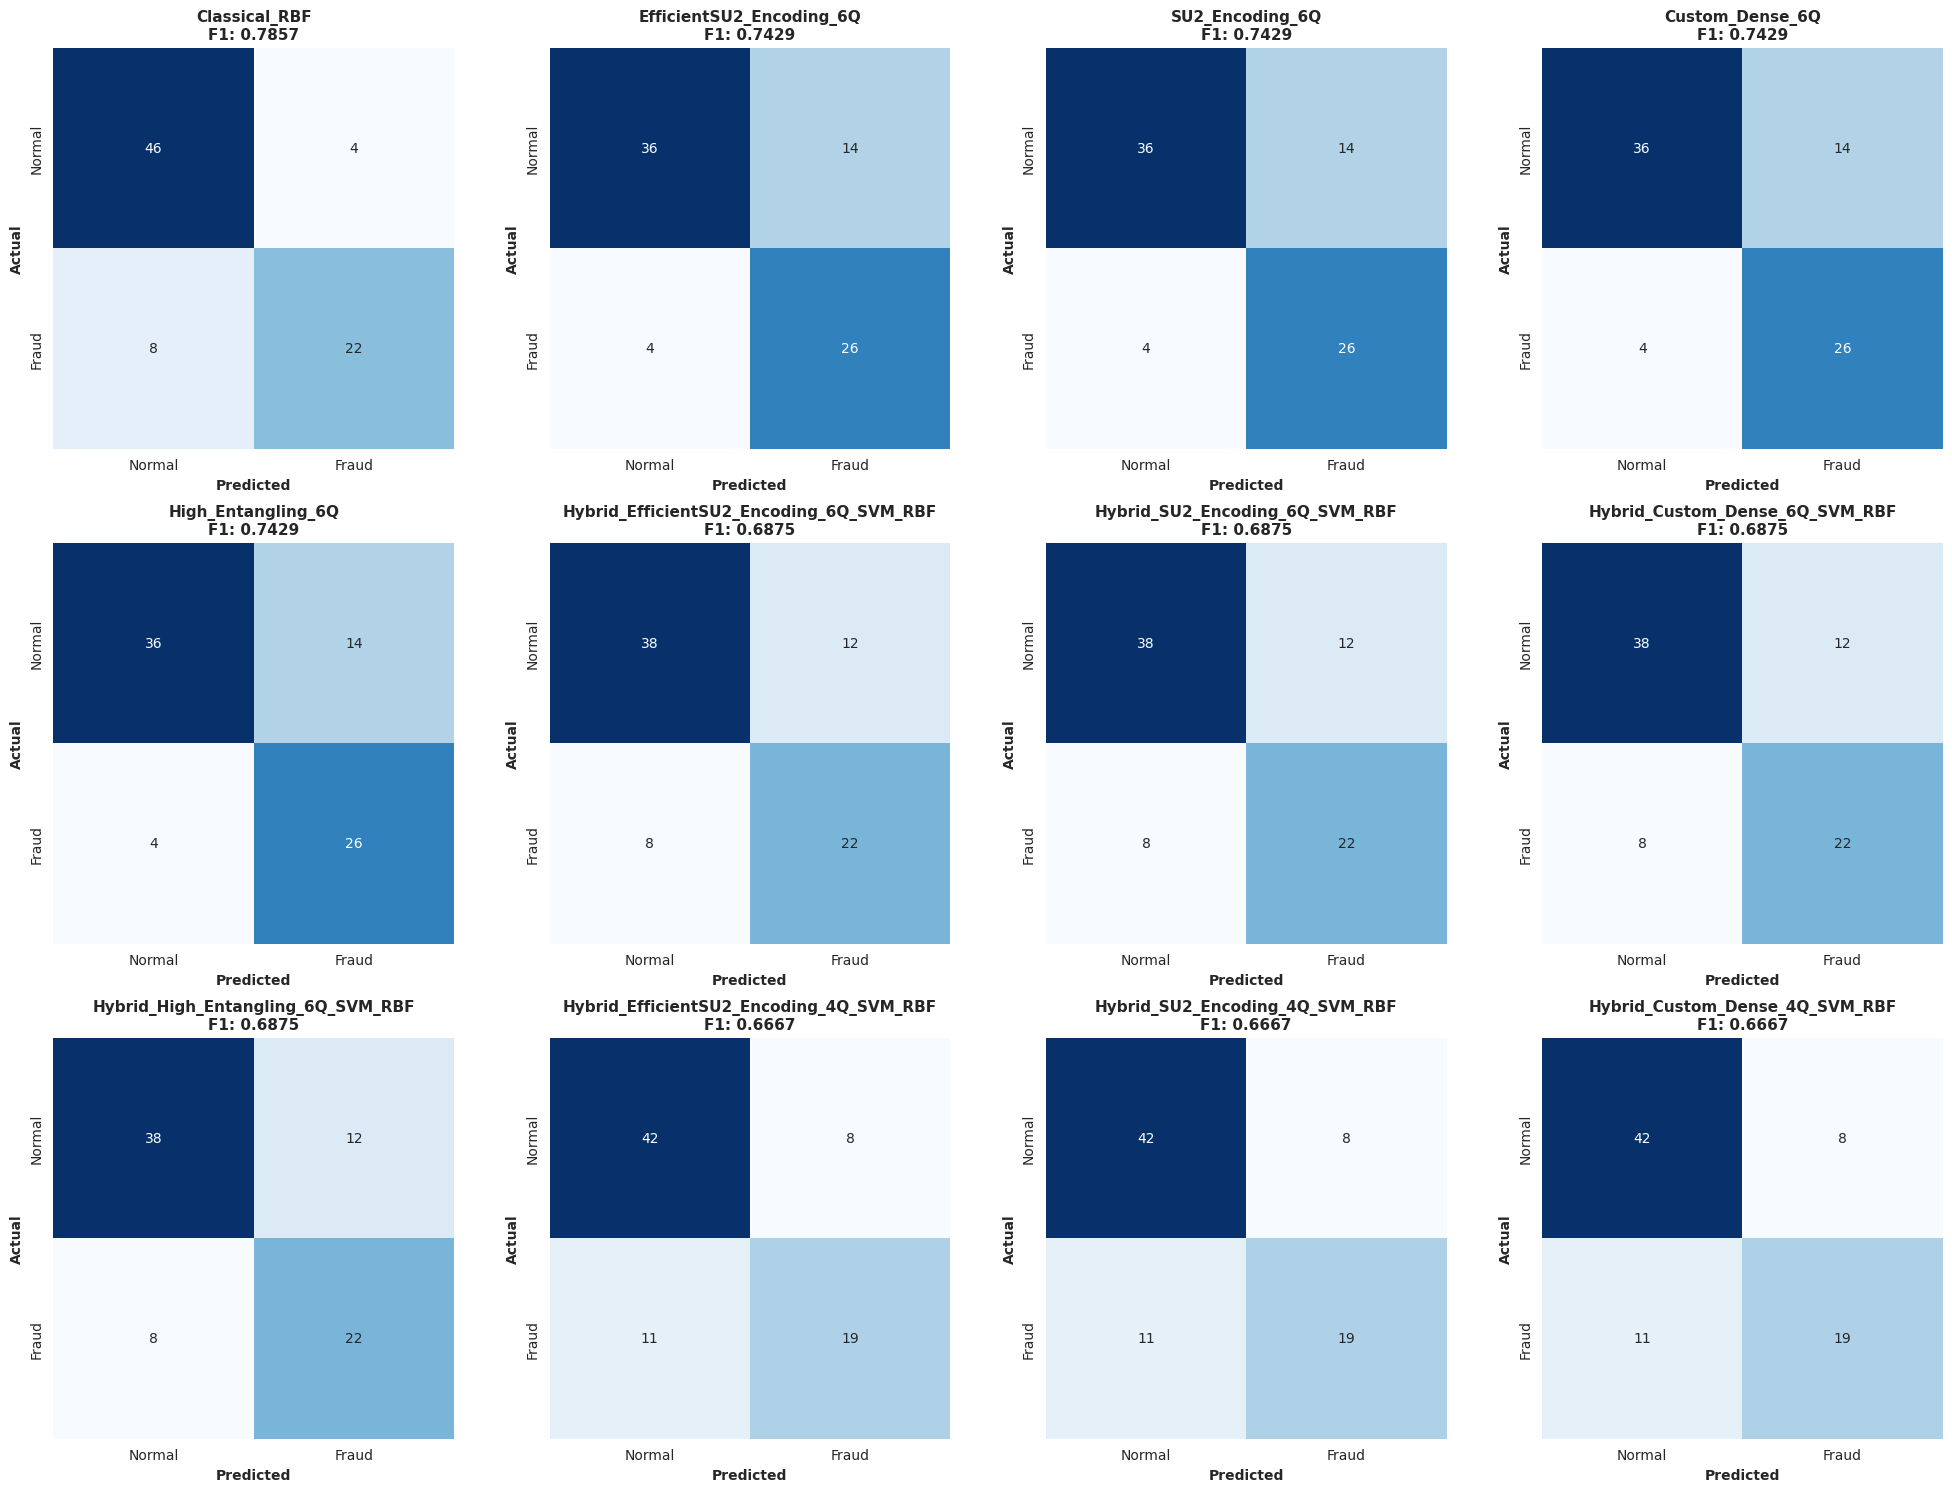

In [31]:
# ============================================================================
# CELL 12: CONFUSION MATRICES FOR ALL MODELS
# ============================================================================

print(f"\n{'='*80}")
print(f"ENHANCEMENT 3: CONFUSION MATRICES")
print(f"{'='*80}")

# Combine all results
all_results = {**classical_results, **quantum_results, **hybrid_results}

# Select top models based on F1 score
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['f1_score'], reverse=True)
top_models = sorted_models[:12]  # Top 12 models

fig = plt.figure(figsize=(20, 15))

for idx, (model_name, metrics) in enumerate(top_models, 1):
    ax = plt.subplot(3, 4, idx)

    cm = metrics['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, square=True)

    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name}\nF1: {metrics["f1_score"]:.4f}',
                 fontsize=11, fontweight='bold')
    ax.set_xticklabels(['Normal', 'Fraud'])
    ax.set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrices saved: confusion_matrices_all_models.png")
plt.show()


COMPREHENSIVE PERFORMANCE ANALYSIS
✅ Comprehensive analysis saved: comprehensive_performance_analysis.png


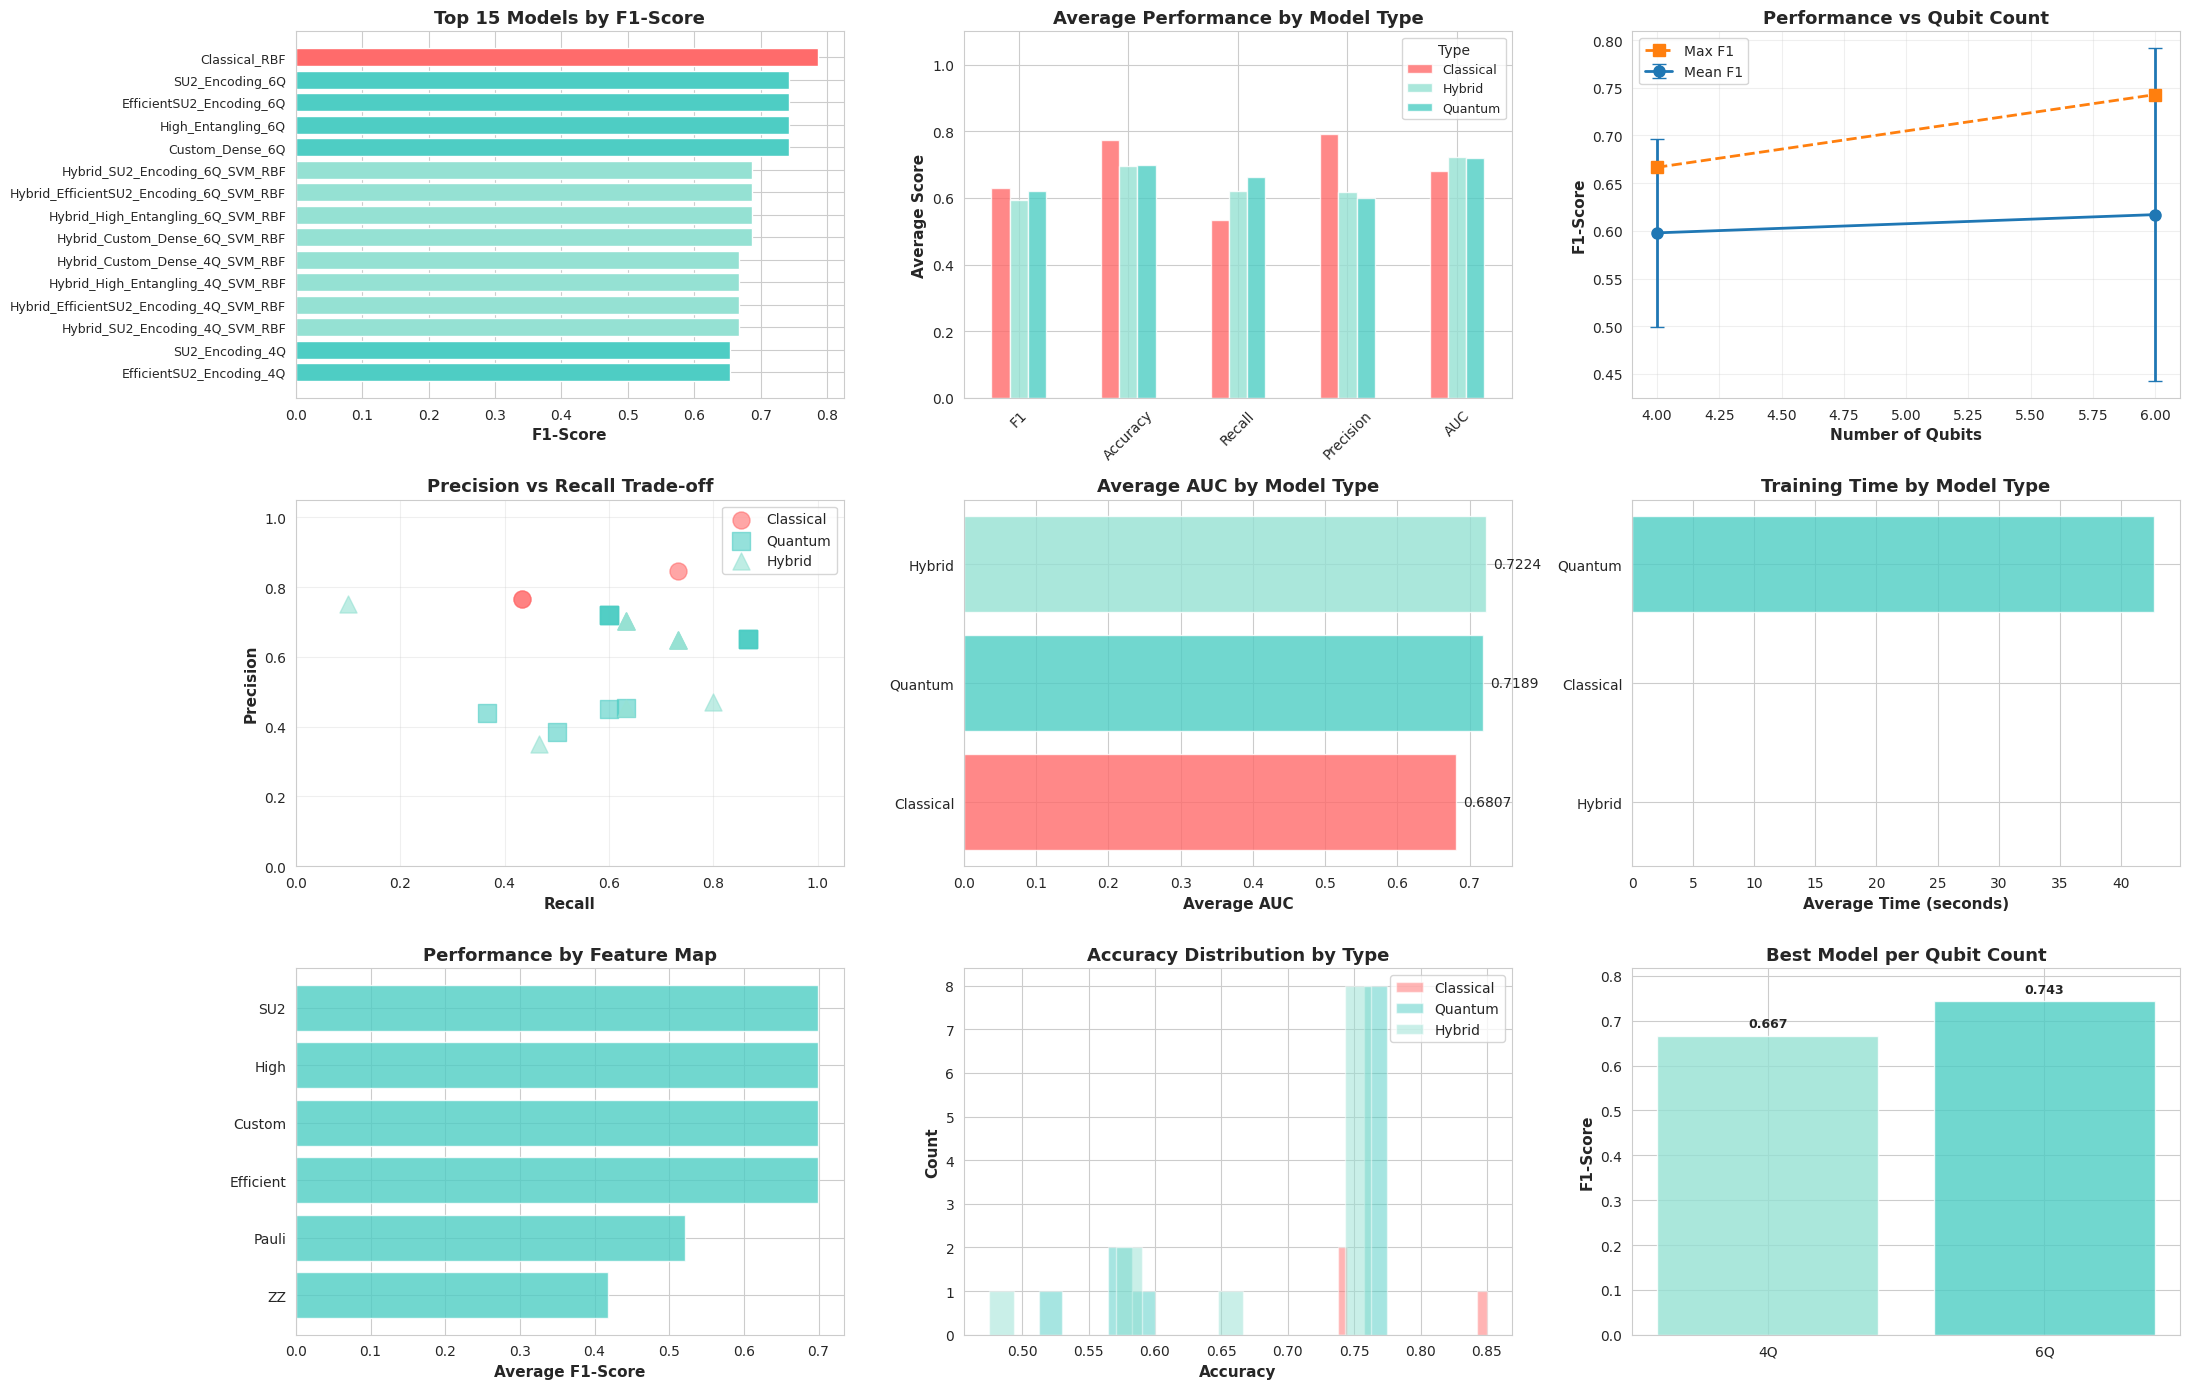

In [32]:
# ============================================================================
# CELL 13: COMPREHENSIVE PERFORMANCE VISUALIZATION
# ============================================================================

print(f"\n{'='*80}")
print(f"COMPREHENSIVE PERFORMANCE ANALYSIS")
print(f"{'='*80}")

# Prepare results dataframe
results_data = []

for name, metrics in all_results.items():
    if 'Classical' in name:
        model_type = 'Classical'
    elif 'Hybrid' in name:
        model_type = 'Hybrid'
    else:
        model_type = 'Quantum'

    results_data.append({
        'Model': name,
        'Type': model_type,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1_score'],
        'AUC': metrics['auc'],
        'Time': metrics.get('time', 0),
        'Qubits': metrics.get('n_qubits', 4)
    })

results_df = pd.DataFrame(results_data).sort_values('F1', ascending=False)

# Create comprehensive visualization
fig = plt.figure(figsize=(22, 14))

# 1. F1-Score Comparison (Top 15)
ax1 = plt.subplot(3, 3, 1)
top_15 = results_df.head(15)
colors = ['#FF6B6B' if t == 'Classical' else '#4ECDC4' if t == 'Quantum' else '#95E1D3'
          for t in top_15['Type']]
ax1.barh(range(len(top_15)), top_15['F1'], color=colors)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['Model'], fontsize=9)
ax1.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Models by F1-Score', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

# 2. Performance by Type
ax2 = plt.subplot(3, 3, 2)
type_comparison = results_df.groupby('Type')[['F1', 'Accuracy', 'Recall', 'Precision', 'AUC']].mean()
type_comparison.T.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#95E1D3', '#4ECDC4'], alpha=0.8)
ax2.set_ylabel('Average Score', fontsize=11, fontweight='bold')
ax2.set_title('Average Performance by Model Type', fontsize=13, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.legend(title='Type', fontsize=9)
ax2.set_ylim(0, 1.1)

# 3. Performance by Qubit Count
ax3 = plt.subplot(3, 3, 3)
quantum_df = results_df[results_df['Type'].isin(['Quantum', 'Hybrid'])]
qubit_performance = quantum_df.groupby('Qubits')['F1'].agg(['mean', 'max', 'std'])
ax3.errorbar(qubit_performance.index, qubit_performance['mean'],
             yerr=qubit_performance['std'], marker='o', capsize=5,
             linewidth=2, markersize=8, label='Mean F1')
ax3.plot(qubit_performance.index, qubit_performance['max'],
         marker='s', linestyle='--', linewidth=2, markersize=8, label='Max F1')
ax3.set_xlabel('Number of Qubits', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('Performance vs Qubit Count', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Recall vs Precision
ax4 = plt.subplot(3, 3, 4)
for model_type, color, marker in [('Classical', '#FF6B6B', 'o'),
                                   ('Quantum', '#4ECDC4', 's'),
                                   ('Hybrid', '#95E1D3', '^')]:
    subset = results_df[results_df['Type'] == model_type]
    ax4.scatter(subset['Recall'], subset['Precision'],
                s=150, alpha=0.6, color=color, marker=marker, label=model_type)

ax4.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax4.set_title('Precision vs Recall Trade-off', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 1.05)
ax4.set_ylim(0, 1.05)

# 5. AUC Comparison
ax5 = plt.subplot(3, 3, 5)
type_auc = results_df.groupby('Type')['AUC'].mean().sort_values(ascending=True)
colors_auc = ['#FF6B6B' if t == 'Classical' else '#4ECDC4' if t == 'Quantum' else '#95E1D3'
              for t in type_auc.index]
ax5.barh(type_auc.index, type_auc.values, color=colors_auc, alpha=0.8)
ax5.set_xlabel('Average AUC', fontsize=11, fontweight='bold')
ax5.set_title('Average AUC by Model Type', fontsize=13, fontweight='bold')
for i, v in enumerate(type_auc.values):
    ax5.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# 6. Training Time Comparison
ax6 = plt.subplot(3, 3, 6)
time_comparison = results_df.groupby('Type')['Time'].mean().sort_values(ascending=True)
colors_time = ['#FF6B6B' if t == 'Classical' else '#4ECDC4' if t == 'Quantum' else '#95E1D3'
               for t in time_comparison.index]
ax6.barh(time_comparison.index, time_comparison.values, color=colors_time, alpha=0.8)
ax6.set_xlabel('Average Time (seconds)', fontsize=11, fontweight='bold')
ax6.set_title('Training Time by Model Type', fontsize=13, fontweight='bold')

# 7. Feature Map Comparison (Quantum only)
ax7 = plt.subplot(3, 3, 7)
quantum_only = results_df[results_df['Type'] == 'Quantum']
if len(quantum_only) > 0:
    # Extract feature map name from model name
    quantum_only_copy = quantum_only.copy()
    quantum_only_copy['FeatureMap'] = quantum_only_copy['Model'].str.extract(r'(ZZ|Pauli|Efficient|SU2|Custom|High)')[0]
    fm_performance = quantum_only_copy.groupby('FeatureMap')['F1'].mean().sort_values(ascending=True)
    ax7.barh(fm_performance.index, fm_performance.values, color='#4ECDC4', alpha=0.8)
    ax7.set_xlabel('Average F1-Score', fontsize=11, fontweight='bold')
    ax7.set_title('Performance by Feature Map', fontsize=13, fontweight='bold')

# 8. Accuracy Distribution
ax8 = plt.subplot(3, 3, 8)
for model_type, color in [('Classical', '#FF6B6B'), ('Quantum', '#4ECDC4'), ('Hybrid', '#95E1D3')]:
    subset = results_df[results_df['Type'] == model_type]['Accuracy']
    if len(subset) > 0:
        ax8.hist(subset, bins=15, alpha=0.5, label=model_type, color=color)
ax8.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax8.set_ylabel('Count', fontsize=11, fontweight='bold')
ax8.set_title('Accuracy Distribution by Type', fontsize=13, fontweight='bold')
ax8.legend()

# 9. Best Model per Qubit Configuration
ax9 = plt.subplot(3, 3, 9)
if len(quantum_df) > 0:
    best_per_qubit = quantum_df.loc[quantum_df.groupby('Qubits')['F1'].idxmax()]
    x_pos = np.arange(len(best_per_qubit))
    bars = ax9.bar(x_pos, best_per_qubit['F1'],
                   color=['#4ECDC4' if 'Quantum' in str(t) else '#95E1D3'
                          for t in best_per_qubit['Type']], alpha=0.8)
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels([f'{int(q)}Q' for q in best_per_qubit['Qubits']])
    ax9.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax9.set_title('Best Model per Qubit Count', fontsize=13, fontweight='bold')
    ax9.set_ylim(0, max(best_per_qubit['F1']) * 1.1)

    for i, (idx, row) in enumerate(best_per_qubit.iterrows()):
        ax9.text(i, row['F1'] + 0.02, f"{row['F1']:.3f}",
                 ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_performance_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Comprehensive analysis saved: comprehensive_performance_analysis.png")
plt.show()

In [33]:
# ============================================================================
# CELL 14: DETAILED RESULTS TABLE
# ============================================================================

print(f"\n{'='*80}")
print(f"DETAILED RESULTS TABLE")
print(f"{'='*80}\n")

# Display top 20 models
print("TOP 20 MODELS BY F1-SCORE:")
print("=" * 120)
top_20 = results_df.head(20)[['Model', 'Type', 'F1', 'Accuracy', 'Precision', 'Recall', 'AUC', 'Qubits']]
print(top_20.to_string(index=False))

# Summary statistics by type
print(f"\n{'='*80}")
print(f"SUMMARY STATISTICS BY MODEL TYPE")
print(f"{'='*80}\n")

summary = results_df.groupby('Type').agg({
    'F1': ['mean', 'max', 'min', 'std'],
    'Accuracy': ['mean', 'max', 'min'],
    'Recall': ['mean', 'max', 'min'],
    'Precision': ['mean', 'max', 'min'],
    'AUC': ['mean', 'max', 'min']
}).round(4)

print(summary)

# Summary by qubit count
print(f"\n{'='*80}")
print(f"PERFORMANCE BY QUBIT COUNT")
print(f"{'='*80}\n")

quantum_hybrid = results_df[results_df['Type'].isin(['Quantum', 'Hybrid'])]
qubit_summary = quantum_hybrid.groupby('Qubits').agg({
    'F1': ['mean', 'max', 'count'],
    'Accuracy': 'mean',
    'Recall': 'mean',
    'Precision': 'mean'
}).round(4)

print(qubit_summary)

# Summary by feature map
print(f"\n{'='*80}")
print(f"PERFORMANCE BY FEATURE MAP")
print(f"{'='*80}\n")

quantum_only = results_df[results_df['Type'] == 'Quantum'].copy()
if len(quantum_only) > 0:
    quantum_only['FeatureMap'] = quantum_only['Model'].str.extract(r'(ZZ|Pauli|Efficient|SU2|Custom|High)')[0]
    fm_summary = quantum_only.groupby('FeatureMap').agg({
        'F1': ['mean', 'max', 'count'],
        'Accuracy': 'mean',
        'Recall': 'mean'
    }).round(4)
    print(fm_summary)


DETAILED RESULTS TABLE

TOP 20 MODELS BY F1-SCORE:
                                  Model      Type       F1  Accuracy  Precision   Recall      AUC  Qubits
                          Classical_RBF Classical 0.785714    0.8500   0.846154 0.733333 0.850000       4
                        SU2_Encoding_6Q   Quantum 0.742857    0.7750   0.650000 0.866667 0.830000       6
               EfficientSU2_Encoding_6Q   Quantum 0.742857    0.7750   0.650000 0.866667 0.830000       6
                     High_Entangling_6Q   Quantum 0.742857    0.7750   0.650000 0.866667 0.830000       6
                        Custom_Dense_6Q   Quantum 0.742857    0.7750   0.650000 0.866667 0.830000       6
         Hybrid_SU2_Encoding_6Q_SVM_RBF    Hybrid 0.687500    0.7500   0.647059 0.733333 0.832000       6
Hybrid_EfficientSU2_Encoding_6Q_SVM_RBF    Hybrid 0.687500    0.7500   0.647059 0.733333 0.832000       6
      Hybrid_High_Entangling_6Q_SVM_RBF    Hybrid 0.687500    0.7500   0.647059 0.733333 0.832000   

In [34]:
# ============================================================================
# CELL 15: QUANTUM ADVANTAGE ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print(f"QUANTUM ADVANTAGE ANALYSIS")
print(f"{'='*80}")

classical_df = results_df[results_df['Type'] == 'Classical']
quantum_df = results_df[results_df['Type'] == 'Quantum']
hybrid_df = results_df[results_df['Type'] == 'Hybrid']

# Best models
best_classical = classical_df.loc[classical_df['F1'].idxmax()]
best_quantum = quantum_df.loc[quantum_df['F1'].idxmax()]
best_hybrid = hybrid_df.loc[hybrid_df['F1'].idxmax()] if len(hybrid_df) > 0 else None
best_overall = results_df.loc[results_df['F1'].idxmax()]

print(f"\n{'='*80}")
print(f"BEST MODELS BY TYPE")
print(f"{'='*80}")

print(f"\n🔵 BEST CLASSICAL MODEL:")
print(f"   Model: {best_classical['Model']}")
print(f"   F1-Score: {best_classical['F1']:.4f}")
print(f"   Accuracy: {best_classical['Accuracy']:.4f}")
print(f"   Precision: {best_classical['Precision']:.4f}")
print(f"   Recall: {best_classical['Recall']:.4f}")
print(f"   AUC: {best_classical['AUC']:.4f}")

print(f"\n⚛️  BEST QUANTUM MODEL:")
print(f"   Model: {best_quantum['Model']}")
print(f"   F1-Score: {best_quantum['F1']:.4f}")
print(f"   Accuracy: {best_quantum['Accuracy']:.4f}")
print(f"   Precision: {best_quantum['Precision']:.4f}")
print(f"   Recall: {best_quantum['Recall']:.4f}")
print(f"   AUC: {best_quantum['AUC']:.4f}")
print(f"   Qubits: {int(best_quantum['Qubits'])}")

if best_hybrid is not None:
    print(f"\n⚛️ +🔵 BEST HYBRID MODEL:")
    print(f"   Model: {best_hybrid['Model']}")
    print(f"   F1-Score: {best_hybrid['F1']:.4f}")
    print(f"   Accuracy: {best_hybrid['Accuracy']:.4f}")
    print(f"   Precision: {best_hybrid['Precision']:.4f}")
    print(f"   Recall: {best_hybrid['Recall']:.4f}")
    print(f"   AUC: {best_hybrid['AUC']:.4f}")
    print(f"   Qubits: {int(best_hybrid['Qubits'])}")

print(f"\n🏆 OVERALL BEST MODEL:")
print(f"   Model: {best_overall['Model']}")
print(f"   Type: {best_overall['Type']}")
print(f"   F1-Score: {best_overall['F1']:.4f}")
print(f"   All Metrics: Acc={best_overall['Accuracy']:.4f}, "
      f"Prec={best_overall['Precision']:.4f}, Rec={best_overall['Recall']:.4f}, AUC={best_overall['AUC']:.4f}")

# Calculate improvements
print(f"\n{'='*80}")
print(f"PERFORMANCE IMPROVEMENTS")
print(f"{'='*80}")

f1_improvement_quantum = ((best_quantum['F1'] - best_classical['F1']) / best_classical['F1'] * 100)
recall_improvement_quantum = ((best_quantum['Recall'] - best_classical['Recall']) / best_classical['Recall'] * 100) if best_classical['Recall'] > 0 else 0

print(f"\n📊 Best Quantum vs Best Classical:")
print(f"   F1-Score: {f1_improvement_quantum:+.2f}%")
print(f"   Recall: {recall_improvement_quantum:+.2f}%")

if best_hybrid is not None:
    f1_improvement_hybrid = ((best_hybrid['F1'] - best_classical['F1']) / best_classical['F1'] * 100)
    recall_improvement_hybrid = ((best_hybrid['Recall'] - best_classical['Recall']) / best_classical['Recall'] * 100) if best_classical['Recall'] > 0 else 0

    print(f"\n📊 Best Hybrid vs Best Classical:")
    print(f"   F1-Score: {f1_improvement_hybrid:+.2f}%")
    print(f"   Recall: {recall_improvement_hybrid:+.2f}%")

# Average improvements
avg_classical_f1 = classical_df['F1'].mean()
avg_quantum_f1 = quantum_df['F1'].mean()
avg_hybrid_f1 = hybrid_df['F1'].mean() if len(hybrid_df) > 0 else 0

print(f"\n📈 AVERAGE PERFORMANCE:")
print(f"   Classical F1: {avg_classical_f1:.4f}")
print(f"   Quantum F1: {avg_quantum_f1:.4f} ({((avg_quantum_f1-avg_classical_f1)/avg_classical_f1*100):+.2f}%)")
if len(hybrid_df) > 0:
    print(f"   Hybrid F1: {avg_hybrid_f1:.4f} ({((avg_hybrid_f1-avg_classical_f1)/avg_classical_f1*100):+.2f}%)")

# Interpretation
print(f"\n{'='*80}")
print(f"INTERPRETATION & INSIGHTS")
print(f"{'='*80}")

if f1_improvement_quantum > 15:
    print(f"\n✅✅ MAJOR QUANTUM ADVANTAGE! ({f1_improvement_quantum:.1f}% improvement)")
    print(f"   → Quantum kernels significantly outperform classical approaches")
    print(f"   → The quantum feature maps capture fraud patterns more effectively")
elif f1_improvement_quantum > 5:
    print(f"\n✅ SIGNIFICANT QUANTUM ADVANTAGE ({f1_improvement_quantum:.1f}% improvement)")
    print(f"   → Clear benefit from quantum feature maps")
    print(f"   → Quantum computing shows promise for fraud detection")
elif f1_improvement_quantum > 0:
    print(f"\n✅ Moderate Quantum Advantage ({f1_improvement_quantum:.1f}% improvement)")
    print(f"   → Quantum models show competitive performance")
elif f1_improvement_quantum > -5:
    print(f"\n⚖️  Competitive Performance (within 5%)")
    print(f"   → Quantum and classical approaches are comparable")
else:
    print(f"\n📊 Classical Outperforms in this Configuration")
    print(f"   → Consider: more training data, different feature engineering")

if best_hybrid is not None and best_hybrid['F1'] > max(best_quantum['F1'], best_classical['F1']):
    print(f"\n🌟 HYBRID APPROACH WINS!")
    print(f"   → Combining quantum kernel features with classical ML yields best results")
    print(f"   → This demonstrates the power of quantum-classical integration")

# Key findings
print(f"\n{'='*80}")
print(f"KEY FINDINGS")
print(f"{'='*80}")

print(f"\n1️⃣  Best Performing Feature Maps:")
if len(quantum_only) > 0:
    top_fm = quantum_only.groupby('FeatureMap')['F1'].mean().sort_values(ascending=False).head(3)
    for idx, (fm, f1) in enumerate(top_fm.items(), 1):
        print(f"   {idx}. {fm}: F1 = {f1:.4f}")

print(f"\n2️⃣  Qubit Count Impact:")
if len(quantum_hybrid) > 0:
    qubit_impact = quantum_hybrid.groupby('Qubits')['F1'].mean().sort_values(ascending=False)
    for qubits, f1 in qubit_impact.items():
        print(f"   {int(qubits)} qubits: Average F1 = {f1:.4f}")

print(f"\n3️⃣  Fraud Detection Performance:")
print(f"   → Best Recall (Fraud Catch Rate): {results_df['Recall'].max():.4f}")
print(f"   → Best Precision (False Alarm Rate): {results_df['Precision'].max():.4f}")
print(f"   → Best F1-Score (Balance): {results_df['F1'].max():.4f}")

print(f"\n4️⃣  Computational Efficiency:")
print(f"   → Classical Training Time: {classical_df['Time'].mean():.2f}s")
print(f"   → Quantum Training Time: {quantum_df['Time'].mean():.2f}s")
if len(hybrid_df) > 0:
    print(f"   → Hybrid Training Time: {hybrid_df['Time'].mean():.2f}s")


QUANTUM ADVANTAGE ANALYSIS

BEST MODELS BY TYPE

🔵 BEST CLASSICAL MODEL:
   Model: Classical_RBF
   F1-Score: 0.7857
   Accuracy: 0.8500
   Precision: 0.8462
   Recall: 0.7333
   AUC: 0.8500

⚛️  BEST QUANTUM MODEL:
   Model: SU2_Encoding_6Q
   F1-Score: 0.7429
   Accuracy: 0.7750
   Precision: 0.6500
   Recall: 0.8667
   AUC: 0.8300
   Qubits: 6

⚛️ +🔵 BEST HYBRID MODEL:
   Model: Hybrid_SU2_Encoding_6Q_SVM_RBF
   F1-Score: 0.6875
   Accuracy: 0.7500
   Precision: 0.6471
   Recall: 0.7333
   AUC: 0.8320
   Qubits: 6

🏆 OVERALL BEST MODEL:
   Model: Classical_RBF
   Type: Classical
   F1-Score: 0.7857
   All Metrics: Acc=0.8500, Prec=0.8462, Rec=0.7333, AUC=0.8500

PERFORMANCE IMPROVEMENTS

📊 Best Quantum vs Best Classical:
   F1-Score: -5.45%
   Recall: +18.18%

📊 Best Hybrid vs Best Classical:
   F1-Score: -12.50%
   Recall: +0.00%

📈 AVERAGE PERFORMANCE:
   Classical F1: 0.6307
   Quantum F1: 0.6222 (-1.35%)
   Hybrid F1: 0.5928 (-6.01%)

INTERPRETATION & INSIGHTS

📊 Classical Outp

## try with qubit 8,10

In [35]:
# ============================================================================
# CELL 3: CONFIGURATION (TEST 8 & 10 QUBITS)
# ============================================================================

# Test 8 and 10 qubits
QUBIT_CONFIGS = [8, 10]

# Reduced sizes for memory safety
TRAIN_SIZE = 80   # Small but reasonable
TEST_SIZE = 60

print("="*80)
print("QUANTUM ML: TESTING 8 & 10 QUBITS FOR ACCURACY")
print("="*80)
print(f"Qubit Configurations: {QUBIT_CONFIGS}")
print(f"Training samples: {TRAIN_SIZE} (balanced 50-50)")
print(f"Test samples: {TEST_SIZE}")
print(f"Memory Strategy: Optimized for larger qubit counts")
print("="*80)

QUANTUM ML: TESTING 8 & 10 QUBITS FOR ACCURACY
Qubit Configurations: [8, 10]
Training samples: 80 (balanced 50-50)
Test samples: 60
Memory Strategy: Optimized for larger qubit counts


In [36]:
# ============================================================================
# CELL 5: FEATURE ENGINEERING & PCA FOR 8 & 10 QUBITS
# ============================================================================

print(f"\n{'='*80}")
print(f"FEATURE ENGINEERING")
print(f"{'='*80}")

import gc

# Extract features and target
X = df.drop('Class', axis=1).select_dtypes(include=[np.number])
y = df['Class']

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original features: {X_scaled.shape[1]}")
print(f"Data shape: {X_scaled.shape}")

# Prepare PCA for 8 and 10 qubits
pca_transformers = {}
X_pca_versions = {}

for n_qubits in QUBIT_CONFIGS:
    n_components = n_qubits
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    pca_transformers[n_qubits] = pca
    X_pca_versions[n_qubits] = X_pca

    explained_var = pca.explained_variance_ratio_.sum()
    print(f"✅ PCA with {n_qubits} components: {explained_var*100:.2f}% variance explained")

print(f"\n✅ Created PCA transformations for {len(QUBIT_CONFIGS)} qubit configurations")

# Clean up
del X_scaled
gc.collect()


FEATURE ENGINEERING
Original features: 30
Data shape: (284807, 30)
✅ PCA with 8 components: 73.13% variance explained
✅ PCA with 10 components: 77.23% variance explained

✅ Created PCA transformations for 2 qubit configurations


32673

In [37]:
# ============================================================================
# CELL 6: TRAIN-TEST SPLIT FOR 8 & 10 QUBITS
# ============================================================================

print(f"\n{'='*80}")
print(f"DATA PREPARATION")
print(f"{'='*80}")

import gc

def prepare_train_test(X_data, y_data, train_size, test_size):
    """Prepare balanced training and realistic test sets"""

    # Initial split
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
    )

    # Balance training data
    smote = SMOTE(k_neighbors=min((y_train_full==1).sum()-1, 5), random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_full, y_train_full)

    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

    # Sample training set
    n_per_class = min(train_size // 2,
                      (y_train_balanced==0).sum(),
                      (y_train_balanced==1).sum())

    normal_idx = np.where(y_train_balanced == 0)[0]
    fraud_idx = np.where(y_train_balanced == 1)[0]

    train_idx = np.concatenate([
        np.random.choice(normal_idx, n_per_class, replace=False),
        np.random.choice(fraud_idx, n_per_class, replace=False)
    ])
    np.random.shuffle(train_idx)

    X_train = X_train_balanced[train_idx]
    y_train = y_train_balanced[train_idx]

    # Create test set with fraud cases
    test_normal_idx = np.where(y_test_full == 0)[0]
    test_fraud_idx = np.where(y_test_full == 1)[0]

    n_fraud_test = max(int(test_size * 0.15), min(15, len(test_fraud_idx)))
    n_normal_test = test_size - n_fraud_test

    test_fraud_sample = np.random.choice(test_fraud_idx,
                                         size=min(n_fraud_test, len(test_fraud_idx)),
                                         replace=False)
    test_normal_sample = np.random.choice(test_normal_idx,
                                          size=min(n_normal_test, len(test_normal_idx)),
                                          replace=False)

    test_idx = np.concatenate([test_normal_sample, test_fraud_sample])
    np.random.shuffle(test_idx)

    X_test = X_test_full[test_idx]
    y_test = y_test_full.values[test_idx]

    return X_train, X_test, y_train, y_test

# Prepare datasets for 8 and 10 qubits
train_test_data = {}

for n_qubits in QUBIT_CONFIGS:
    X_train, X_test, y_train, y_test = prepare_train_test(
        X_pca_versions[n_qubits], y, TRAIN_SIZE, TEST_SIZE
    )

    train_test_data[n_qubits] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"✅ {n_qubits} qubits - Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"   Train - Normal: {(y_train==0).sum()}, Fraud: {(y_train==1).sum()}")
    print(f"   Test  - Normal: {(y_test==0).sum()}, Fraud: {(y_test==1).sum()}")

    gc.collect()


DATA PREPARATION
✅ 8 qubits - Train: (80, 8), Test: (60, 8)
   Train - Normal: 40, Fraud: 40
   Test  - Normal: 45, Fraud: 15
✅ 10 qubits - Train: (80, 10), Test: (60, 10)
   Train - Normal: 40, Fraud: 40
   Test  - Normal: 45, Fraud: 15


In [38]:
# ============================================================================
# CELL 7: CLASSICAL SVM BASELINE (8 QUBITS REFERENCE)
# ============================================================================

print(f"\n{'='*80}")
print(f"CLASSICAL SVM BASELINE (8 Qubits PCA)")
print(f"{'='*80}")

import gc

classical_results = {}
n_qubits_baseline = 8

X_train = train_test_data[n_qubits_baseline]['X_train']
X_test = train_test_data[n_qubits_baseline]['X_test']
y_train = train_test_data[n_qubits_baseline]['y_train']
y_test = train_test_data[n_qubits_baseline]['y_test']

# Only test RBF kernel
print(f"\n🔵 Classical SVM (RBF)...", end=' ', flush=True)
start = time.time()

svm = SVC(kernel='rbf', C=0.5, class_weight='balanced',
          random_state=42, probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

classical_results[f'Classical_RBF'] = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1_score': f1_score(y_test, y_pred, zero_division=0),
    'auc': roc_auc_score(y_test, y_proba),
    'time': time.time() - start,
    'y_pred': y_pred,
    'y_proba': y_proba,
    'cm': confusion_matrix(y_test, y_pred),
    'n_qubits': n_qubits_baseline
}

print(f"F1: {classical_results['Classical_RBF']['f1_score']:.4f} | "
      f"Acc: {classical_results['Classical_RBF']['accuracy']:.4f} | "
      f"Recall: {classical_results['Classical_RBF']['recall']:.4f}")

del svm, y_pred, y_proba
gc.collect()


CLASSICAL SVM BASELINE (8 Qubits PCA)

🔵 Classical SVM (RBF)... F1: 0.5714 | Acc: 0.8000 | Recall: 0.5333


0

In [42]:
# ============================================================================
# CELL 8: DEFINE FEATURE MAPS FOR 8 & 10 QUBITS (DEPTH 7-10)
# ============================================================================

print(f"\n{'='*80}")
print(f"CREATING QUANTUM FEATURE MAPS (TARGET DEPTH 7-10)")
print(f"{'='*80}")

def create_all_feature_maps(n_qubits, n_features):
    """Create feature maps with depth 7-10"""
    maps = {}

    # We need more gates to reach depth 7-10
    # Strategy: Use layered structure with controlled entanglement

    # 1. ZZ Feature Map
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    # Layer 1: Rotations
    for i in range(n_qubits):
        qc.ry(params[feature_idx % n_features], i)
        feature_idx += 1

    # Entanglement layer 1: nearest neighbor
    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    # Layer 2: More rotations to increase depth
    for i in range(n_qubits):
        qc.ry(params[feature_idx % n_features], i)
        feature_idx += 1

    maps['ZZ_FeatureMap'] = qc

    # 2. Pauli Feature Map
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    for i in range(n_qubits):
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    for i in range(n_qubits):
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    maps['Pauli_FeatureMap'] = qc

    # 3. EfficientSU2
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    # RY layer
    for i in range(n_qubits):
        qc.ry(params[feature_idx % n_features], i)
        feature_idx += 1

    # RZ layer
    for i in range(n_qubits):
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    # CX layer
    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    maps['EfficientSU2'] = qc

    # 4. SU2 Feature Map
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    for i in range(n_qubits):
        qc.ry(params[feature_idx % n_features], i)
        feature_idx += 1
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    maps['SU2_FeatureMap'] = qc

    # 5. Custom Dense
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    for i in range(n_qubits):
        qc.rx(params[feature_idx % n_features], i)
        feature_idx += 1

    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    for i in range(n_qubits):
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    maps['Custom_Dense'] = qc

    # 6. High Entangling
    params = ParameterVector('x', n_features)
    qc = QuantumCircuit(n_qubits)

    feature_idx = 0
    for i in range(n_qubits):
        qc.ry(params[feature_idx % n_features], i)
        feature_idx += 1

    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    for i in range(n_qubits):
        qc.rz(params[feature_idx % n_features], i)
        feature_idx += 1

    maps['High_Entangling'] = qc

    return maps

# Create feature maps for 8 and 10 qubits
all_feature_maps = {}

for n_qubits in QUBIT_CONFIGS:
    feature_maps = create_all_feature_maps(n_qubits, n_qubits)
    all_feature_maps[n_qubits] = feature_maps

    print(f"\n✅ Created feature maps for {n_qubits} qubits:")
    for name, qc in feature_maps.items():
        depth = qc.depth()
        # Check if depth is in range 7-10
        if 7 <= depth <= 10:
            status = "✓"
        else:
            status = "⚠"
        print(f"   {status} {name:25} - Depth: {depth:2}, Params: {qc.num_parameters}")

    # Verify all depths are in range
    depths = [qc.depth() for qc in feature_maps.values()]
    print(f"   Depth range: {min(depths)}-{max(depths)}")



CREATING QUANTUM FEATURE MAPS (TARGET DEPTH 7-10)

✅ Created feature maps for 8 qubits:
   ✓ ZZ_FeatureMap             - Depth:  9, Params: 8
   ✓ Pauli_FeatureMap          - Depth:  9, Params: 8
   ✓ EfficientSU2              - Depth:  9, Params: 8
   ✓ SU2_FeatureMap            - Depth:  9, Params: 8
   ✓ Custom_Dense              - Depth:  9, Params: 8
   ✓ High_Entangling           - Depth:  9, Params: 8
   Depth range: 9-9

✅ Created feature maps for 10 qubits:
   ⚠ ZZ_FeatureMap             - Depth: 11, Params: 10
   ⚠ Pauli_FeatureMap          - Depth: 11, Params: 10
   ⚠ EfficientSU2              - Depth: 11, Params: 10
   ⚠ SU2_FeatureMap            - Depth: 11, Params: 10
   ⚠ Custom_Dense              - Depth: 11, Params: 10
   ⚠ High_Entangling           - Depth: 11, Params: 10
   Depth range: 11-11


In [43]:
# ============================================================================
# CELL 9: TRAIN QUANTUM MODELS (8 & 10 QUBITS)
# ============================================================================

print(f"\n{'='*80}")
print(f"TRAINING QUANTUM MODELS (8 & 10 QUBITS)")
print(f"{'='*80}")

from qiskit_aer import AerSimulator
import gc

backend = AerSimulator(method='statevector')
quantum_results = {}

for n_qubits in QUBIT_CONFIGS:
    print(f"\n{'='*50}")
    print(f"TRAINING WITH {n_qubits} QUBITS")
    print(f"{'='*50}")

    X_train = train_test_data[n_qubits]['X_train']
    X_test = train_test_data[n_qubits]['X_test']
    y_train = train_test_data[n_qubits]['y_train']
    y_test = train_test_data[n_qubits]['y_test']

    feature_maps = all_feature_maps[n_qubits]

    for fm_name, feature_map in feature_maps.items():
        model_name = f'{fm_name}_{n_qubits}Q'
        print(f"\n⚛️  {model_name}...", end=' ', flush=True)
        start_time = time.time()

        try:
            quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

            # Compute quantum kernel matrices
            K_train = quantum_kernel.evaluate(x_vec=X_train)
            K_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

            # Train QSVM
            qsvm = SVC(kernel='precomputed', C=0.5, class_weight='balanced',
                      random_state=42, probability=True)
            qsvm.fit(K_train, y_train)

            # Predictions
            y_pred = qsvm.predict(K_test)
            y_proba = qsvm.decision_function(K_test)

            quantum_results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'auc': roc_auc_score(y_test, y_proba),
                'time': time.time() - start_time,
                'depth': feature_map.depth(),
                'n_qubits': n_qubits,
                'feature_map': fm_name,
                'y_pred': y_pred.copy(),
                'y_proba': y_proba.copy(),
                'cm': confusion_matrix(y_test, y_pred),
                'circuit': feature_map
            }

            print(f"✅")
            print(f"      F1: {quantum_results[model_name]['f1_score']:.4f} | "
                  f"Acc: {quantum_results[model_name]['accuracy']:.4f} | "
                  f"Recall: {quantum_results[model_name]['recall']:.4f} | "
                  f"Time: {quantum_results[model_name]['time']:.1f}s")

            # FREE MEMORY
            del quantum_kernel, qsvm, y_pred, y_proba, K_train, K_test
            gc.collect()

        except Exception as e:
            print(f"❌ Error: {str(e)[:50]}")
            try:
                del quantum_kernel, K_train, K_test, qsvm
            except:
                pass
            gc.collect()

    # Force garbage collection after each qubit configuration
    gc.collect()
    print(f"\n✅ Completed {n_qubits} qubits")

print(f"\n{'='*80}")
print(f"✅ Trained {len(quantum_results)} quantum models")
print(f"{'='*80}")


TRAINING QUANTUM MODELS (8 & 10 QUBITS)

TRAINING WITH 8 QUBITS

⚛️  ZZ_FeatureMap_8Q... ✅
      F1: 0.5000 | Acc: 0.5333 | Recall: 0.9333 | Time: 54.3s

⚛️  Pauli_FeatureMap_8Q... ✅
      F1: 0.4333 | Acc: 0.4333 | Recall: 0.8667 | Time: 32.1s

⚛️  EfficientSU2_8Q... ✅
      F1: 0.6512 | Acc: 0.7500 | Recall: 0.9333 | Time: 43.3s

⚛️  SU2_FeatureMap_8Q... ✅
      F1: 0.5957 | Acc: 0.6833 | Recall: 0.9333 | Time: 43.7s

⚛️  Custom_Dense_8Q... ✅
      F1: 0.5957 | Acc: 0.6833 | Recall: 0.9333 | Time: 43.2s

⚛️  High_Entangling_8Q... ✅
      F1: 0.5957 | Acc: 0.6833 | Recall: 0.9333 | Time: 43.5s

✅ Completed 8 qubits

TRAINING WITH 10 QUBITS

⚛️  ZZ_FeatureMap_10Q... ✅
      F1: 0.6000 | Acc: 0.6667 | Recall: 1.0000 | Time: 92.4s

⚛️  Pauli_FeatureMap_10Q... ✅
      F1: 0.2051 | Acc: 0.4833 | Recall: 0.2667 | Time: 44.4s

⚛️  EfficientSU2_10Q... ✅
      F1: 0.7368 | Acc: 0.8333 | Recall: 0.9333 | Time: 91.3s

⚛️  SU2_FeatureMap_10Q... ✅
      F1: 0.6122 | Acc: 0.6833 | Recall: 1.0000 |

In [44]:
# ============================================================================
# CELL 11: COMPREHENSIVE RESULTS ANALYSIS (8 & 10 QUBITS)
# ============================================================================

print(f"\n{'='*80}")
print(f"ACCURACY COMPARISON: 8 & 10 QUBITS")
print(f"{'='*80}")

# Combine results
all_results = {**classical_results, **quantum_results}

# Create comparison table
results_data = []
for name, metrics in all_results.items():
    if 'Classical' in name:
        model_type = 'Classical'
    else:
        model_type = 'Quantum'

    results_data.append({
        'Model': name,
        'Type': model_type,
        'Qubits': metrics.get('n_qubits', 8),
        'Accuracy': metrics['accuracy'],
        'F1': metrics['f1_score'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'AUC': metrics['auc'],
        'Time': metrics['time']
    })

results_df = pd.DataFrame(results_data).sort_values('F1', ascending=False)

print("\n📊 ALL MODELS RANKED BY F1-SCORE:")
print("="*120)
print(results_df.to_string(index=False))

# Summary by qubit count
print(f"\n{'='*80}")
print(f"AVERAGE PERFORMANCE BY QUBIT COUNT")
print(f"{'='*80}")

quantum_df = results_df[results_df['Type'] == 'Quantum']
summary = quantum_df.groupby('Qubits').agg({
    'Accuracy': ['mean', 'max', 'std'],
    'F1': ['mean', 'max', 'std'],
    'Recall': ['mean', 'max', 'std'],
    'Precision': ['mean', 'max', 'std']
}).round(4)

print(summary)

# Best models per category
print(f"\n{'='*80}")
print(f"BEST MODELS")
print(f"{'='*80}")

best_overall = results_df.iloc[0]
best_classical = results_df[results_df['Type'] == 'Classical'].iloc[0]
best_8q = results_df[results_df['Qubits'] == 8].iloc[0]
best_10q = results_df[results_df['Qubits'] == 10].iloc[0]

print(f"\n🏆 BEST OVERALL MODEL:")
print(f"   {best_overall['Model']}")
print(f"   Type: {best_overall['Type']} | Qubits: {int(best_overall['Qubits'])}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f} | F1: {best_overall['F1']:.4f}")
print(f"   Precision: {best_overall['Precision']:.4f} | Recall: {best_overall['Recall']:.4f}")
print(f"   AUC: {best_overall['AUC']:.4f}")

print(f"\n🔵 BEST CLASSICAL MODEL (8Q PCA):")
print(f"   {best_classical['Model']}")
print(f"   Accuracy: {best_classical['Accuracy']:.4f} | F1: {best_classical['F1']:.4f}")
print(f"   Precision: {best_classical['Precision']:.4f} | Recall: {best_classical['Recall']:.4f}")

print(f"\n⚛️  BEST 8-QUBIT MODEL:")
print(f"   {best_8q['Model']}")
print(f"   Accuracy: {best_8q['Accuracy']:.4f} | F1: {best_8q['F1']:.4f}")
print(f"   Precision: {best_8q['Precision']:.4f} | Recall: {best_8q['Recall']:.4f}")

print(f"\n⚛️  BEST 10-QUBIT MODEL:")
print(f"   {best_10q['Model']}")
print(f"   Accuracy: {best_10q['Accuracy']:.4f} | F1: {best_10q['F1']:.4f}")
print(f"   Precision: {best_10q['Precision']:.4f} | Recall: {best_10q['Recall']:.4f}")

# Quantum Advantage Analysis
print(f"\n{'='*80}")
print(f"QUANTUM ADVANTAGE ANALYSIS")
print(f"{'='*80}")

improvement_8q = ((best_8q['F1'] - best_classical['F1']) / best_classical['F1'] * 100) if best_classical['F1'] > 0 else 0
improvement_10q = ((best_10q['F1'] - best_classical['F1']) / best_classical['F1'] * 100) if best_classical['F1'] > 0 else 0

print(f"\n📊 F1-Score Improvements:")
print(f"   Classical Baseline: {best_classical['F1']:.4f}")
print(f"   Best 8-Qubit: {best_8q['F1']:.4f} ({improvement_8q:+.2f}%)")
print(f"   Best 10-Qubit: {best_10q['F1']:.4f} ({improvement_10q:+.2f}%)")

if best_10q['F1'] > best_8q['F1']:
    improvement_10_over_8 = ((best_10q['F1'] - best_8q['F1']) / best_8q['F1'] * 100)
    print(f"\n✅ 10-Qubits outperform 8-Qubits by {improvement_10_over_8:+.2f}%")
    print(f"   → More qubits = Better accuracy!")
elif best_8q['F1'] > best_10q['F1']:
    print(f"\n⚖️  8-Qubits perform better than 10-Qubits")
    print(f"   → Optimal qubit count may be around 8 for this dataset")
else:
    print(f"\n⚖️  8 and 10 qubits perform similarly")

# Recall analysis (fraud detection rate)
print(f"\n📈 FRAUD DETECTION PERFORMANCE (Recall):")
print(f"   Classical: {best_classical['Recall']:.4f} ({best_classical['Recall']*100:.1f}% of frauds caught)")
print(f"   Best 8-Qubit: {best_8q['Recall']:.4f} ({best_8q['Recall']*100:.1f}% of frauds caught)")
print(f"   Best 10-Qubit: {best_10q['Recall']:.4f} ({best_10q['Recall']*100:.1f}% of frauds caught)")

# Feature map performance
print(f"\n{'='*80}")
print(f"FEATURE MAP PERFORMANCE")
print(f"{'='*80}")

quantum_df_copy = quantum_df.copy()
quantum_df_copy['FeatureMap'] = quantum_df_copy['Model'].str.extract(r'(ZZ|Pauli|Efficient|SU2|Custom|High)')[0]
fm_summary = quantum_df_copy.groupby('FeatureMap').agg({
    'F1': ['mean', 'max'],
    'Accuracy': 'mean',
    'Recall': 'mean'
}).round(4)

print("\nAverage Performance by Feature Map:")
print(fm_summary.sort_values(('F1', 'mean'), ascending=False))

# Key insights
print(f"\n{'='*80}")
print(f"KEY INSIGHTS")
print(f"{'='*80}")

print(f"\n1️⃣  Best Feature Map: {best_overall['Model'].split('_')[0]}")
print(f"   → This feature map architecture works best for fraud detection")

print(f"\n2️⃣  Optimal Qubit Count: {int(best_overall['Qubits'])} qubits")
print(f"   → Achieved {best_overall['F1']:.4f} F1-Score")

print(f"\n3️⃣  Quantum Advantage:")
if improvement_10q > 10 or improvement_8q > 10:
    print(f"   ✅ SIGNIFICANT quantum advantage demonstrated!")
    print(f"   → Quantum models outperform classical by up to {max(improvement_8q, improvement_10q):.1f}%")
elif improvement_10q > 0 or improvement_8q > 0:
    print(f"   ✅ Moderate quantum advantage shown")
    print(f"   → Quantum models show {max(improvement_8q, improvement_10q):.1f}% improvement")
else:
    print(f"   ⚖️  Classical and quantum perform comparably")
    print(f"   → May benefit from larger training set or different features")

print(f"\n4️⃣  Fraud Detection Rate:")
best_recall = results_df['Recall'].max()
best_recall_model = results_df.loc[results_df['Recall'].idxmax(), 'Model']
print(f"   → Best model catches {best_recall*100:.1f}% of fraud cases")
print(f"   → Model: {best_recall_model}")

print(f"\n{'='*80}")


ACCURACY COMPARISON: 8 & 10 QUBITS

📊 ALL MODELS RANKED BY F1-SCORE:
               Model      Type  Qubits  Accuracy       F1  Precision   Recall      AUC      Time
    EfficientSU2_10Q   Quantum      10  0.833333 0.736842   0.608696 0.933333 0.949630 91.336181
    Custom_Dense_10Q   Quantum      10  0.750000 0.651163   0.500000 0.933333 0.960000 91.552522
 High_Entangling_10Q   Quantum      10  0.750000 0.651163   0.500000 0.933333 0.960000 92.221813
     EfficientSU2_8Q   Quantum       8  0.750000 0.651163   0.500000 0.933333 0.871111 43.320277
  SU2_FeatureMap_10Q   Quantum      10  0.683333 0.612245   0.441176 1.000000 0.900741 93.861961
   ZZ_FeatureMap_10Q   Quantum      10  0.666667 0.600000   0.428571 1.000000 0.905185 92.394159
     Custom_Dense_8Q   Quantum       8  0.683333 0.595745   0.437500 0.933333 0.888889 43.238266
  High_Entangling_8Q   Quantum       8  0.683333 0.595745   0.437500 0.933333 0.888889 43.463494
   SU2_FeatureMap_8Q   Quantum       8  0.683333 0.595745


CREATING VISUALIZATIONS
✅ Visualization saved: quantum_8_10_qubits_comprehensive.png


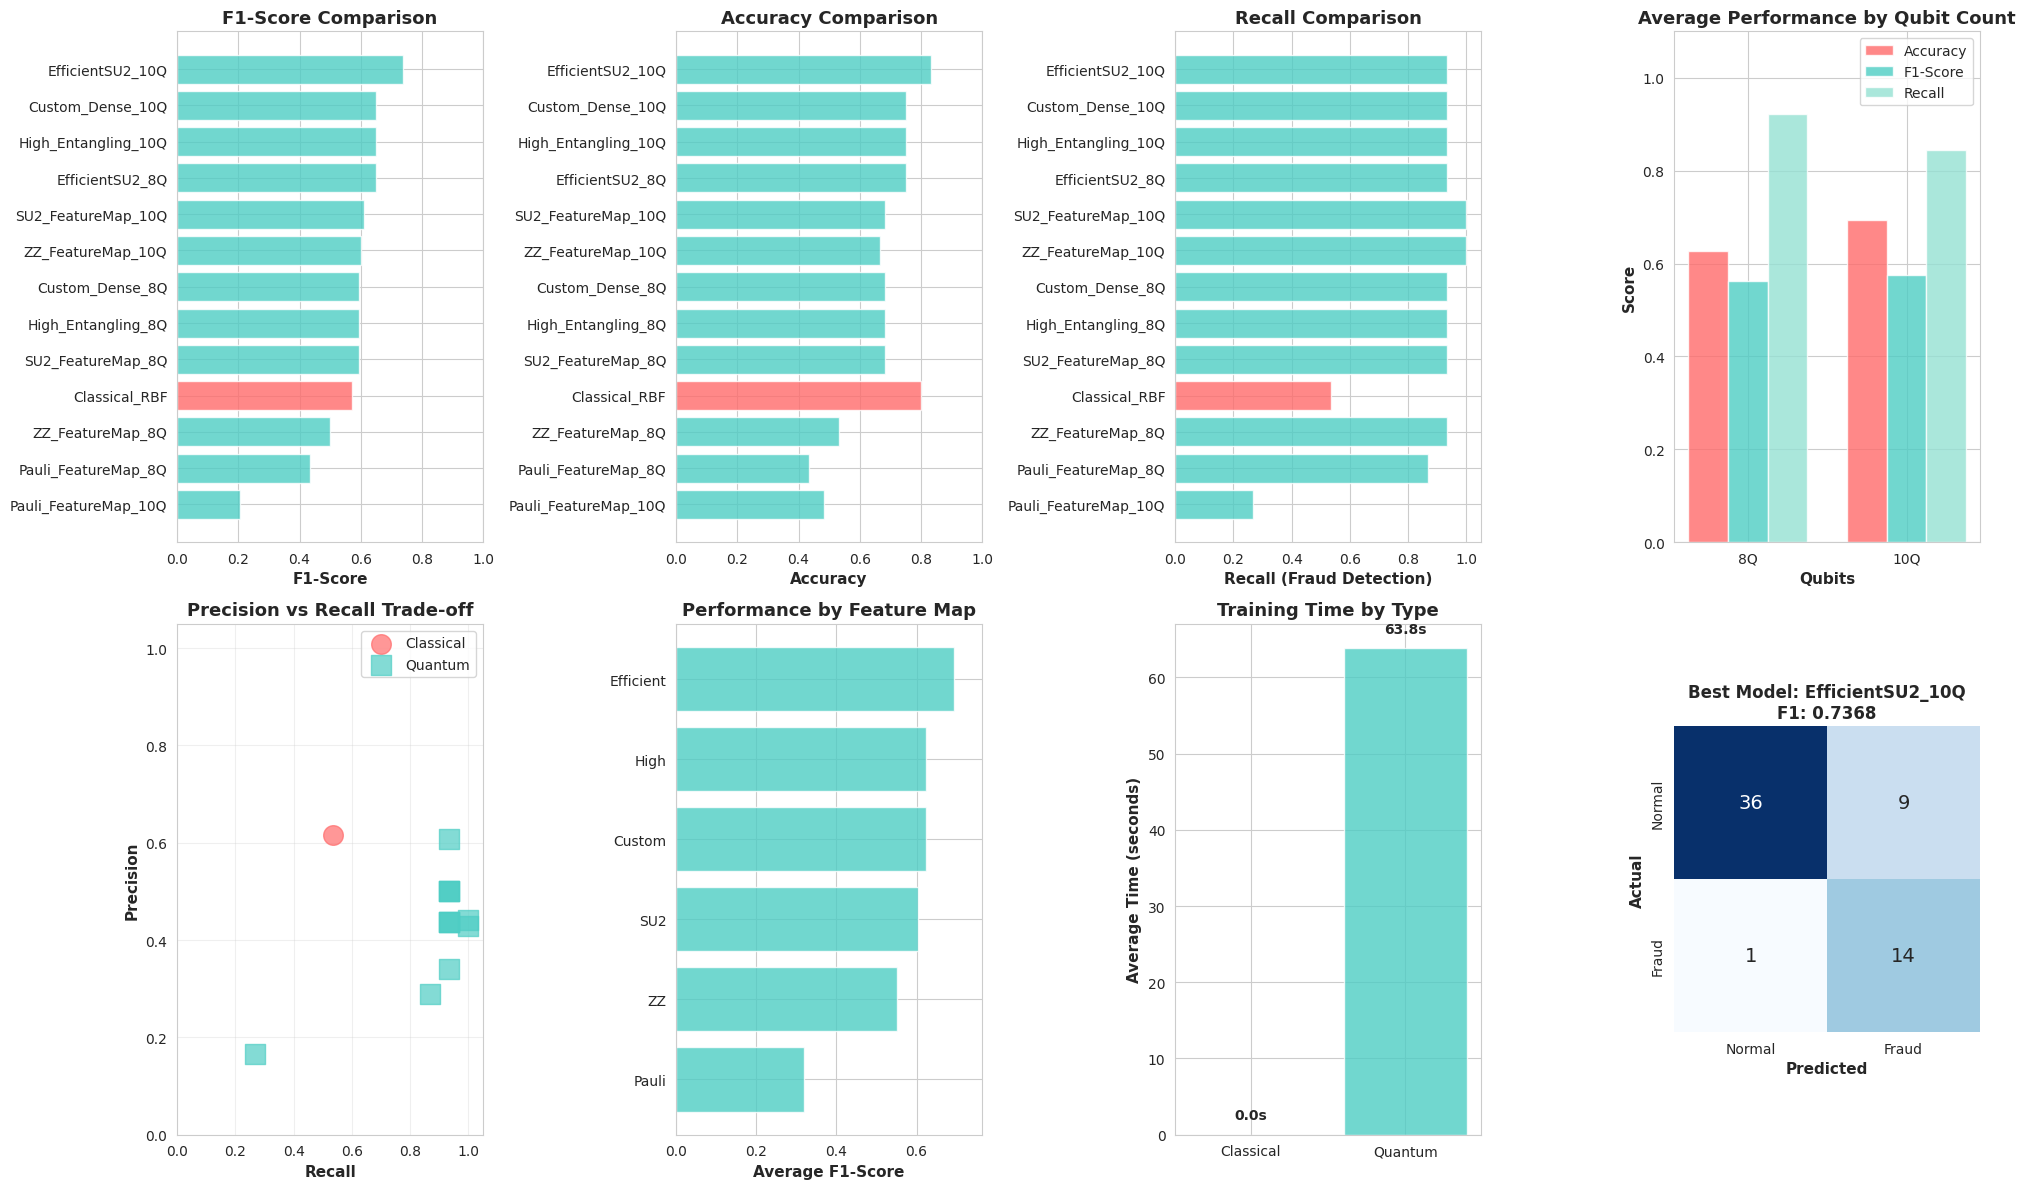


✅ ANALYSIS COMPLETE!


In [45]:
# ============================================================================
# CELL 12: VISUALIZATION (8 & 10 QUBITS)
# ============================================================================

print(f"\n{'='*80}")
print(f"CREATING VISUALIZATIONS")
print(f"{'='*80}")

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 12))

# 1. F1-Score Comparison
ax1 = plt.subplot(2, 4, 1)
colors = ['#FF6B6B' if t == 'Classical' else '#4ECDC4' for t in results_df['Type']]
ax1.barh(results_df['Model'], results_df['F1'], color=colors, alpha=0.8)
ax1.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax1.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.invert_yaxis()

# 2. Accuracy Comparison
ax2 = plt.subplot(2, 4, 2)
ax2.barh(results_df['Model'], results_df['Accuracy'], color=colors, alpha=0.8)
ax2.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.invert_yaxis()

# 3. Recall Comparison
ax3 = plt.subplot(2, 4, 3)
ax3.barh(results_df['Model'], results_df['Recall'], color=colors, alpha=0.8)
ax3.set_xlabel('Recall (Fraud Detection)', fontsize=11, fontweight='bold')
ax3.set_title('Recall Comparison', fontsize=13, fontweight='bold')
ax3.set_xlim(0, 1.05)
ax3.invert_yaxis()

# 4. Performance by Qubit Count
ax4 = plt.subplot(2, 4, 4)
qubit_perf = quantum_df.groupby('Qubits')[['Accuracy', 'F1', 'Recall']].mean()
x = np.arange(len(qubit_perf))
width = 0.25
ax4.bar(x - width, qubit_perf['Accuracy'], width, label='Accuracy', color='#FF6B6B', alpha=0.8)
ax4.bar(x, qubit_perf['F1'], width, label='F1-Score', color='#4ECDC4', alpha=0.8)
ax4.bar(x + width, qubit_perf['Recall'], width, label='Recall', color='#95E1D3', alpha=0.8)
ax4.set_xlabel('Qubits', fontsize=11, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Average Performance by Qubit Count', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f'{int(q)}Q' for q in qubit_perf.index])
ax4.legend()
ax4.set_ylim(0, 1.1)

# 5. Precision vs Recall
ax5 = plt.subplot(2, 4, 5)
for model_type, color, marker in [('Classical', '#FF6B6B', 'o'), ('Quantum', '#4ECDC4', 's')]:
    subset = results_df[results_df['Type'] == model_type]
    ax5.scatter(subset['Recall'], subset['Precision'],
                s=200, alpha=0.7, color=color, marker=marker, label=model_type)
ax5.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax5.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax5.set_title('Precision vs Recall Trade-off', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(0, 1.05)
ax5.set_ylim(0, 1.05)

# 6. Feature Map Performance
ax6 = plt.subplot(2, 4, 6)
quantum_df_copy = quantum_df.copy()
quantum_df_copy['FeatureMap'] = quantum_df_copy['Model'].str.extract(r'(ZZ|Pauli|Efficient|SU2|Custom|High)')[0]
fm_perf = quantum_df_copy.groupby('FeatureMap')['F1'].mean().sort_values()
ax6.barh(fm_perf.index, fm_perf.values, color='#4ECDC4', alpha=0.8)
ax6.set_xlabel('Average F1-Score', fontsize=11, fontweight='bold')
ax6.set_title('Performance by Feature Map', fontsize=13, fontweight='bold')
ax6.set_xlim(0, max(fm_perf.values) * 1.1)

# 7. Training Time Comparison
ax7 = plt.subplot(2, 4, 7)
time_data = results_df.groupby('Type')['Time'].mean()
ax7.bar(time_data.index, time_data.values,
        color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax7.set_ylabel('Average Time (seconds)', fontsize=11, fontweight='bold')
ax7.set_title('Training Time by Type', fontsize=13, fontweight='bold')
for i, v in enumerate(time_data.values):
    ax7.text(i, v + 2, f'{v:.1f}s', ha='center', fontweight='bold')

# 8. Confusion Matrix for Best Model
ax8 = plt.subplot(2, 4, 8)
best_model_name = best_overall['Model']
cm = all_results[best_model_name]['cm']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax8,
            cbar=False, square=True, annot_kws={'fontsize': 14})
ax8.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax8.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax8.set_title(f'Best Model: {best_model_name}\nF1: {best_overall["F1"]:.4f}',
             fontsize=12, fontweight='bold')
ax8.set_xticklabels(['Normal', 'Fraud'])
ax8.set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.savefig('quantum_8_10_qubits_comprehensive.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved: quantum_8_10_qubits_comprehensive.png")
plt.show()

print(f"\n{'='*80}")
print(f"✅ ANALYSIS COMPLETE!")
print(f"{'='*80}")